In [1]:
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = "png2x"
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 200
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

# Next-generation ground-based telescopes

In addition to modeling exoplanet oberservations using telescopes that don't have a coronagraph, the `coronagraph` model can be used to model observations for the upcoming 30-40m class ground-based observatories. The model integrates the ESO SkyCalc command line interface to get an accurate estimate of the flux coming from the sky, with a variety of parameters to choose from. Here we will walk through a few examples of how to use the SkyCalc feature. 



In [3]:
import coronagraph as cg
print(cg.__version__)

1.01


Let's start out by loading a model spectrum of the Earth:

In [74]:
lam, tdepth, fplan, fstar = cg.get_earth_trans_spectrum()

Now we'll define the telescope/instrument parameters for our simulation. The E-ELT at Paranal will have a 39 meter mirror, and we will estimate a 50% throughput for now with a mirror temperature at absolute zero so there is no thermal noise.

# VISIBLE

In [75]:
telescope = cg.Telescope(Tput = 0.5,      # Throughput
                         D = 39.,         # Diameter [m]
                         R = 70,          # Resolving power (lam / dlam)
                         lammin  = 0.5,   # Minimum Wavelength [um]
                         lammax  = 2.5,  # Maximum Wavelength [um]
                         Tsys = 0.0,      # Telescope mirror temperature [K]
                        )  

We'll define the observed system as an Earth-Sun analog at 10 pc. 

In [76]:
planet = cg.Planet(a = 1.0,   # Semi-major axis [AU]
                   d = 10.0,  # Distance [pc]
                   Rp = 1.0   # Planet Radius [Earth Radii]
                  )

star = cg.Star(Rs = 1.0,      # Stellar Radius [Solar Radii]
               Teff = 5700.   # Stellar Effective Temperature [K]
              )

Next, since this is a ground-based telescope, Earth's atmosphere will affect observations. We must model the flux coming from the sky and include it in our calculations. We can begin by instantiating a SkyFlux object and printing the default parameters:

In [7]:
skyflux = cg.SkyFlux()
skyflux.wmin = telescope.lammin * 1000
skyflux.wmax = telescope.lammax * 1000
print(skyflux)

Sky Flux: 
---------
- Airmass : 1.0
- PWV Mode : pwv
- Season  : 0
- Time of Night  : 0 
- Precipitable Water Vapor (PWV) [mm]  : 3.5 
- Monthly Averaged Solar Flux [sfu=0.01 MJy]  : 130.0 
- Include Scattered Moonlight?  : Y 
- Separation of Sun and Moon as seen from Earth [deg] : 90.0 
- Separation of Moon and target [deg]  : 45.0 
- Moon altitude over horizon  : 45.0 
- Moon-Earth distance (mean=1)  : 1.0 
- Include scattered starlight?  : Y 
- Include zodiacal light?  : Y 
- Heliocentric ecliptic longitude [deg]  : 135.0 
- Ecliptic latitude [deg]  : 90.0 
- Include molecular emission of lower atmosphere?  : Y 
- Include molecular emission of upper atmosphere?  : Y 
- Include upper airglow continuum?  : Y 
- Include instrumental thermal radiation?  : N 
- Instrumental temperature 1  : 0.0 
- Instrumental emmisivity 1  : 0.0 
- Instrumental temperature 2  : 0.0 
- Instrumental emmisivity 2  : 0.0 
- Instrumental temperature 3  : 0.0 
- Instrumental emmisivity 3  : 0.0 
- Calculatio

It is not enough to simply instantiate this object. After confirming that the parameters are the ones we want, we must call the `run_skycalc` function:

In [8]:
skyflux.run_skycalc('./visible_skyflux.fits')

RUNNING: skycalc_cli -i .//skycalc_params.txt -o ./testing.fits -a .//almanac_params.txt
DONE


Now let's specify the transit/eclipse duration `tdur` for the planet (Earth in this case), the number of eclipses to observe `ntran`, and the amount of observing out-of-eclipse (in units of eclipse durations) for each secondary eclipse observation `nout`. We're going to simulate the spectrum we would get after observing 1000 secondary eclipses of the Earth passing behind the Sun. Obviously this is ridiculous. One thousand secondary eclipses is not only a minimum of 8000 hours of observational time, but it would take 1000 years to aquire such a dataset! I promise that there is a lesson to be leared here, so let's push forward into infeasibility.

In [17]:
tdur = 8.0 * 60 * 60  # Transit/Eclipse duration [seconds]
ntran = 1e9           # Number of eclipses
nout = 2.0            # Number of out-of-eclipse durations [transit durations]
wantsnr = 10.0        # Desired S/N per resolution element (when applicable)

Now, we're ready to instantiate an `EclipseNoise` object for our simulation, which contains all of the information needed to perform the noise calculation. Let's instantiate an `EclipseNoise` object with and without the sky flux so we can compare them later.

In [18]:
en_nosky = cg.EclipseNoise(tdur = tdur,            # Transit Duration
                          telescope = telescope,  # Telescope object
                          planet = planet,        # Planet object
                          star = star,            # Star object
                          ntran = ntran,          # Number of eclipses to observe
                          nout = nout,            # Number of out-of-eclipse observing
                          wantsnr = wantsnr)      # Desired S/N per resolution element (when applicable)

en_sky = cg.EclipseNoise(tdur = tdur,            # Transit Duration
                         telescope = telescope,  # Telescope object
                         planet = planet,        # Planet object
                         star = star,            # Star object
                         skyflux = skyflux,      # SkyFlux object
                         ntran = ntran,          # Number of eclipses to observe
                         nout = nout,            # Number of out-of-eclipse observing
                         wantsnr = wantsnr,      # Desired S/N per resolution element (when applicable)
                         GROUND = 'SKYFLUX')     # Specify that you want to use the SkyFlux method

en_sky_orig = cg.EclipseNoise(tdur = tdur,            # Transit Duration
                         telescope = telescope,  # Telescope object
                         planet = planet,        # Planet object
                         star = star,            # Star object
                         skyflux = None,      # SkyFlux object
                         ntran = ntran,          # Number of eclipses to observe
                         nout = nout,            # Number of out-of-eclipse observing
                         wantsnr = wantsnr,      # Desired S/N per resolution element (when applicable)
                         GROUND = 'ESO')     # Specify that you want to use the SkyFlux method

We are ready to run the simulations, so we can call the `run_count_rates` method:

In [19]:
en_nosky.run_count_rates(lam, fplan, fstar)

In [20]:
en_sky.run_count_rates(lam, fplan, fstar)

In [21]:
en_sky_orig.run_count_rates(lam, fplan, fstar)

Let's now plot our fiducial secondary eclipse spectra:

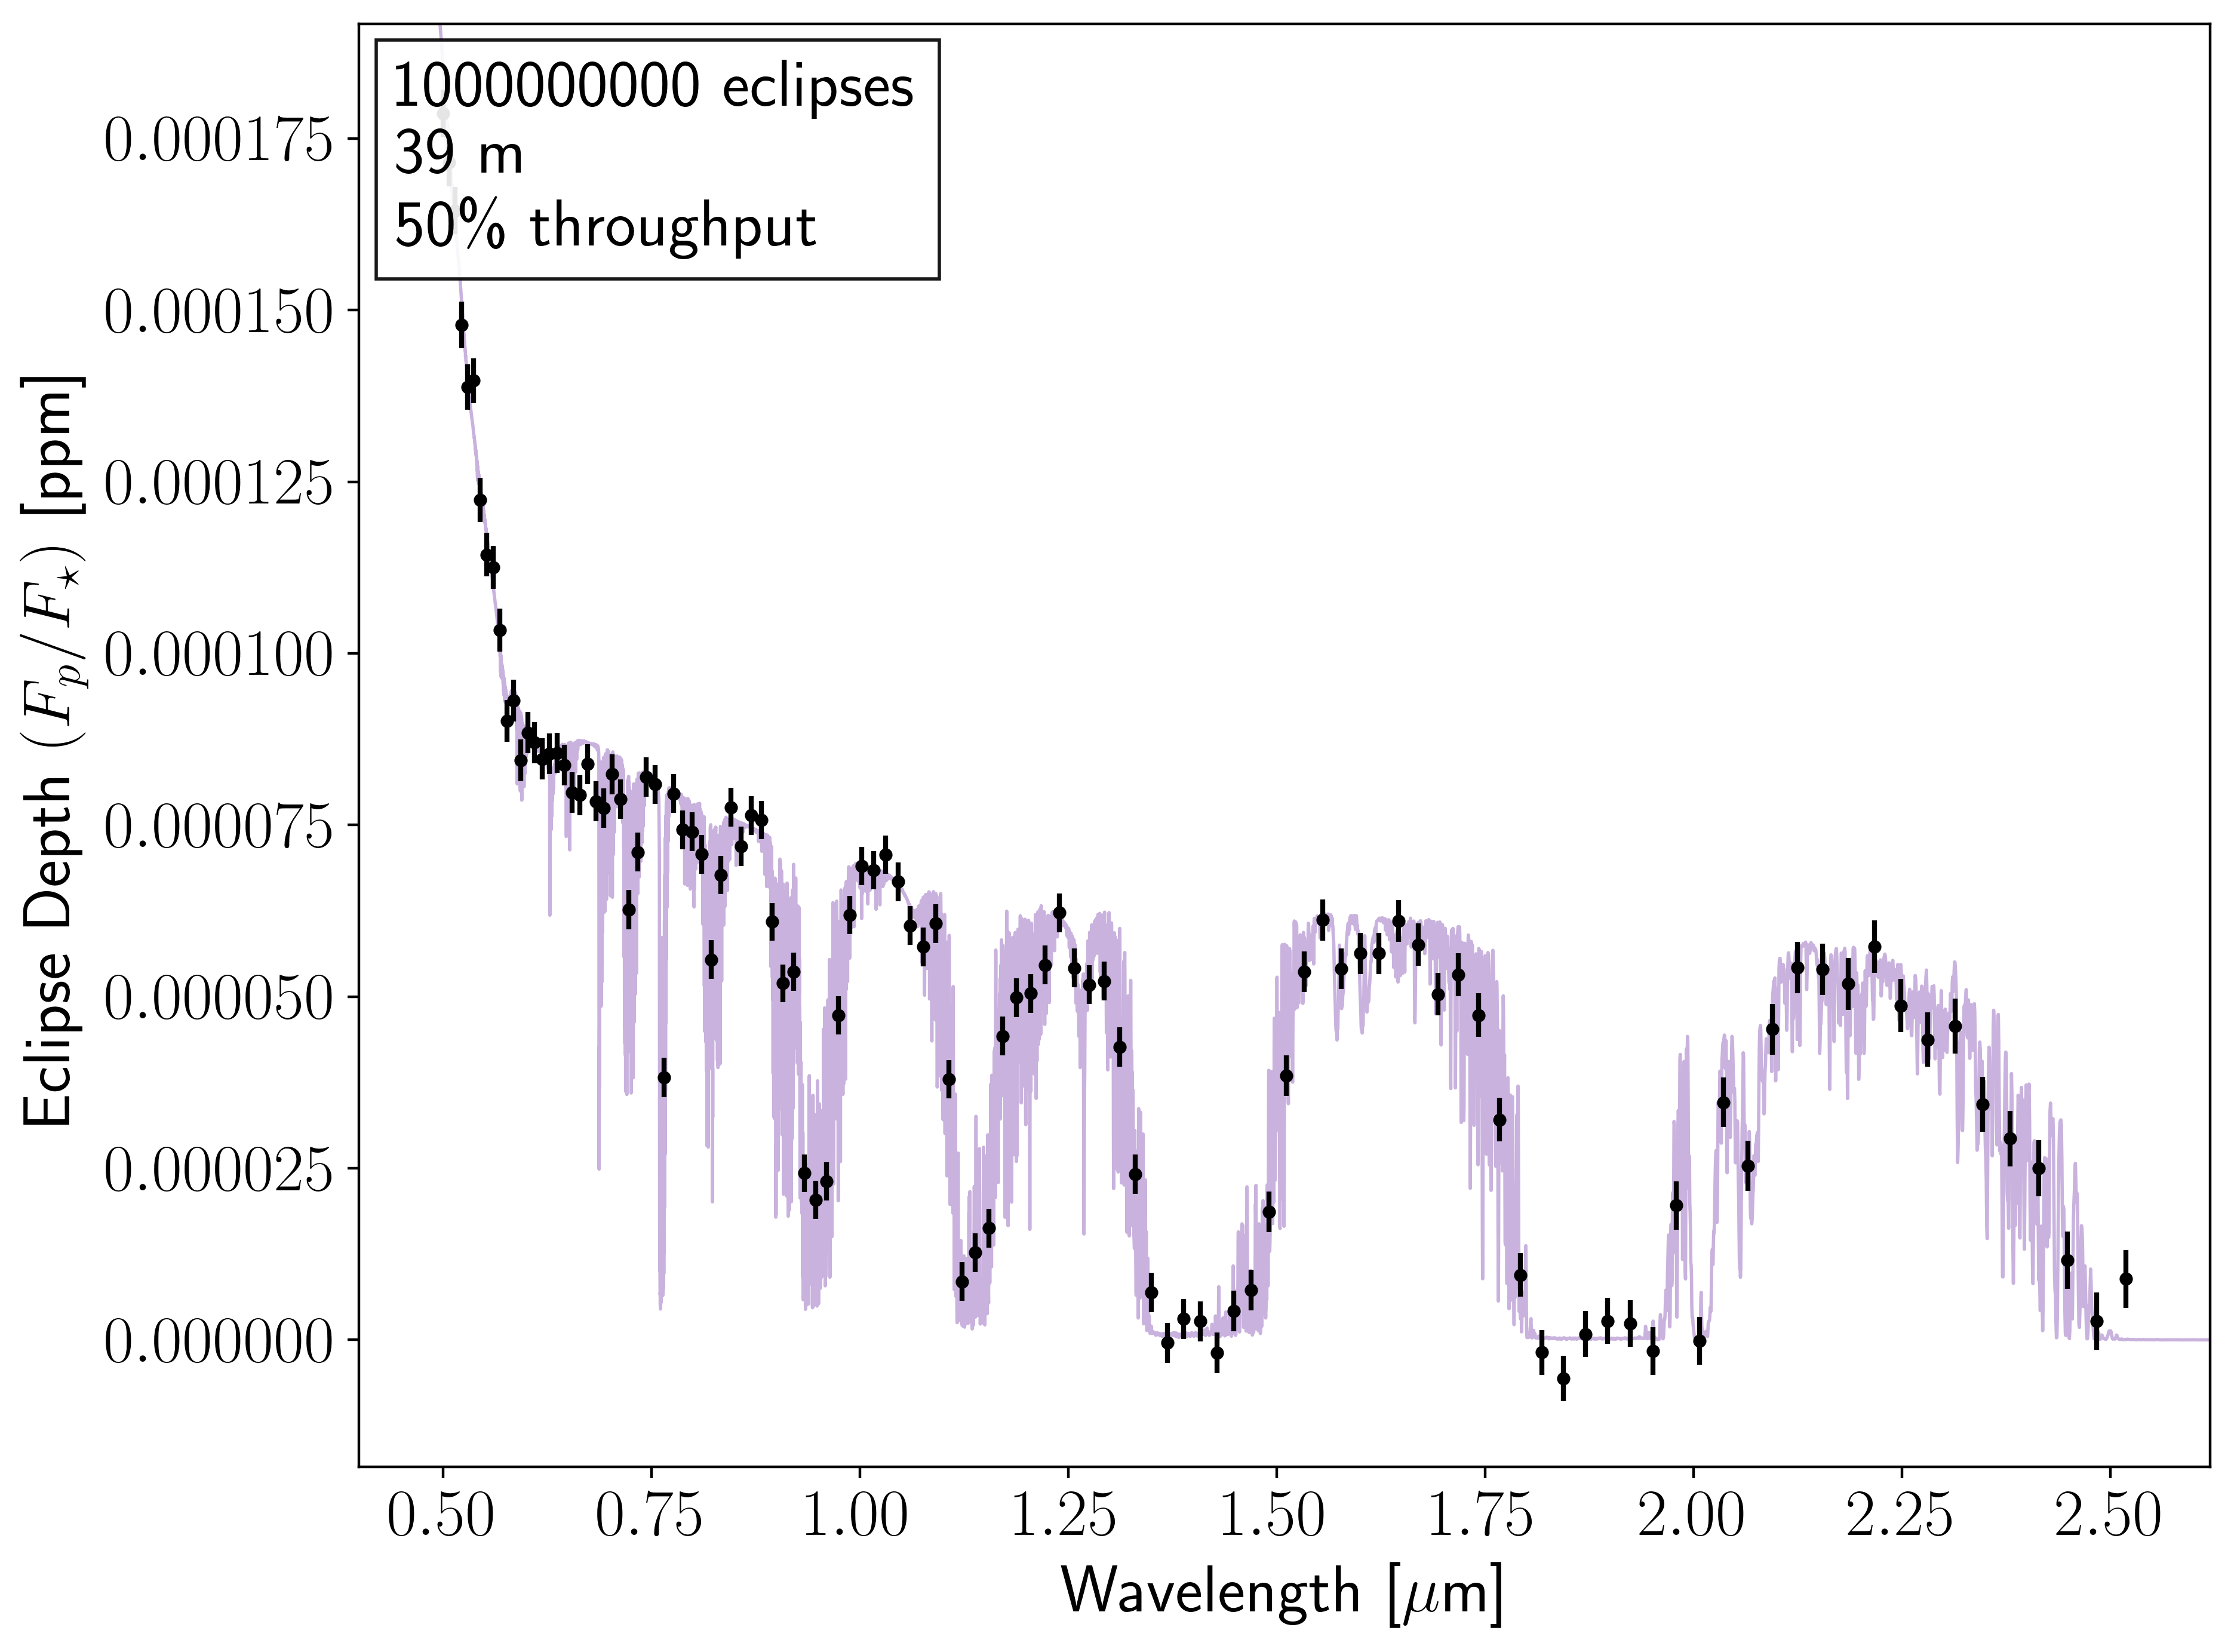

In [22]:
fig, ax = en_nosky.plot_spectrum(SNR_threshold=0.0, Nsig=None)

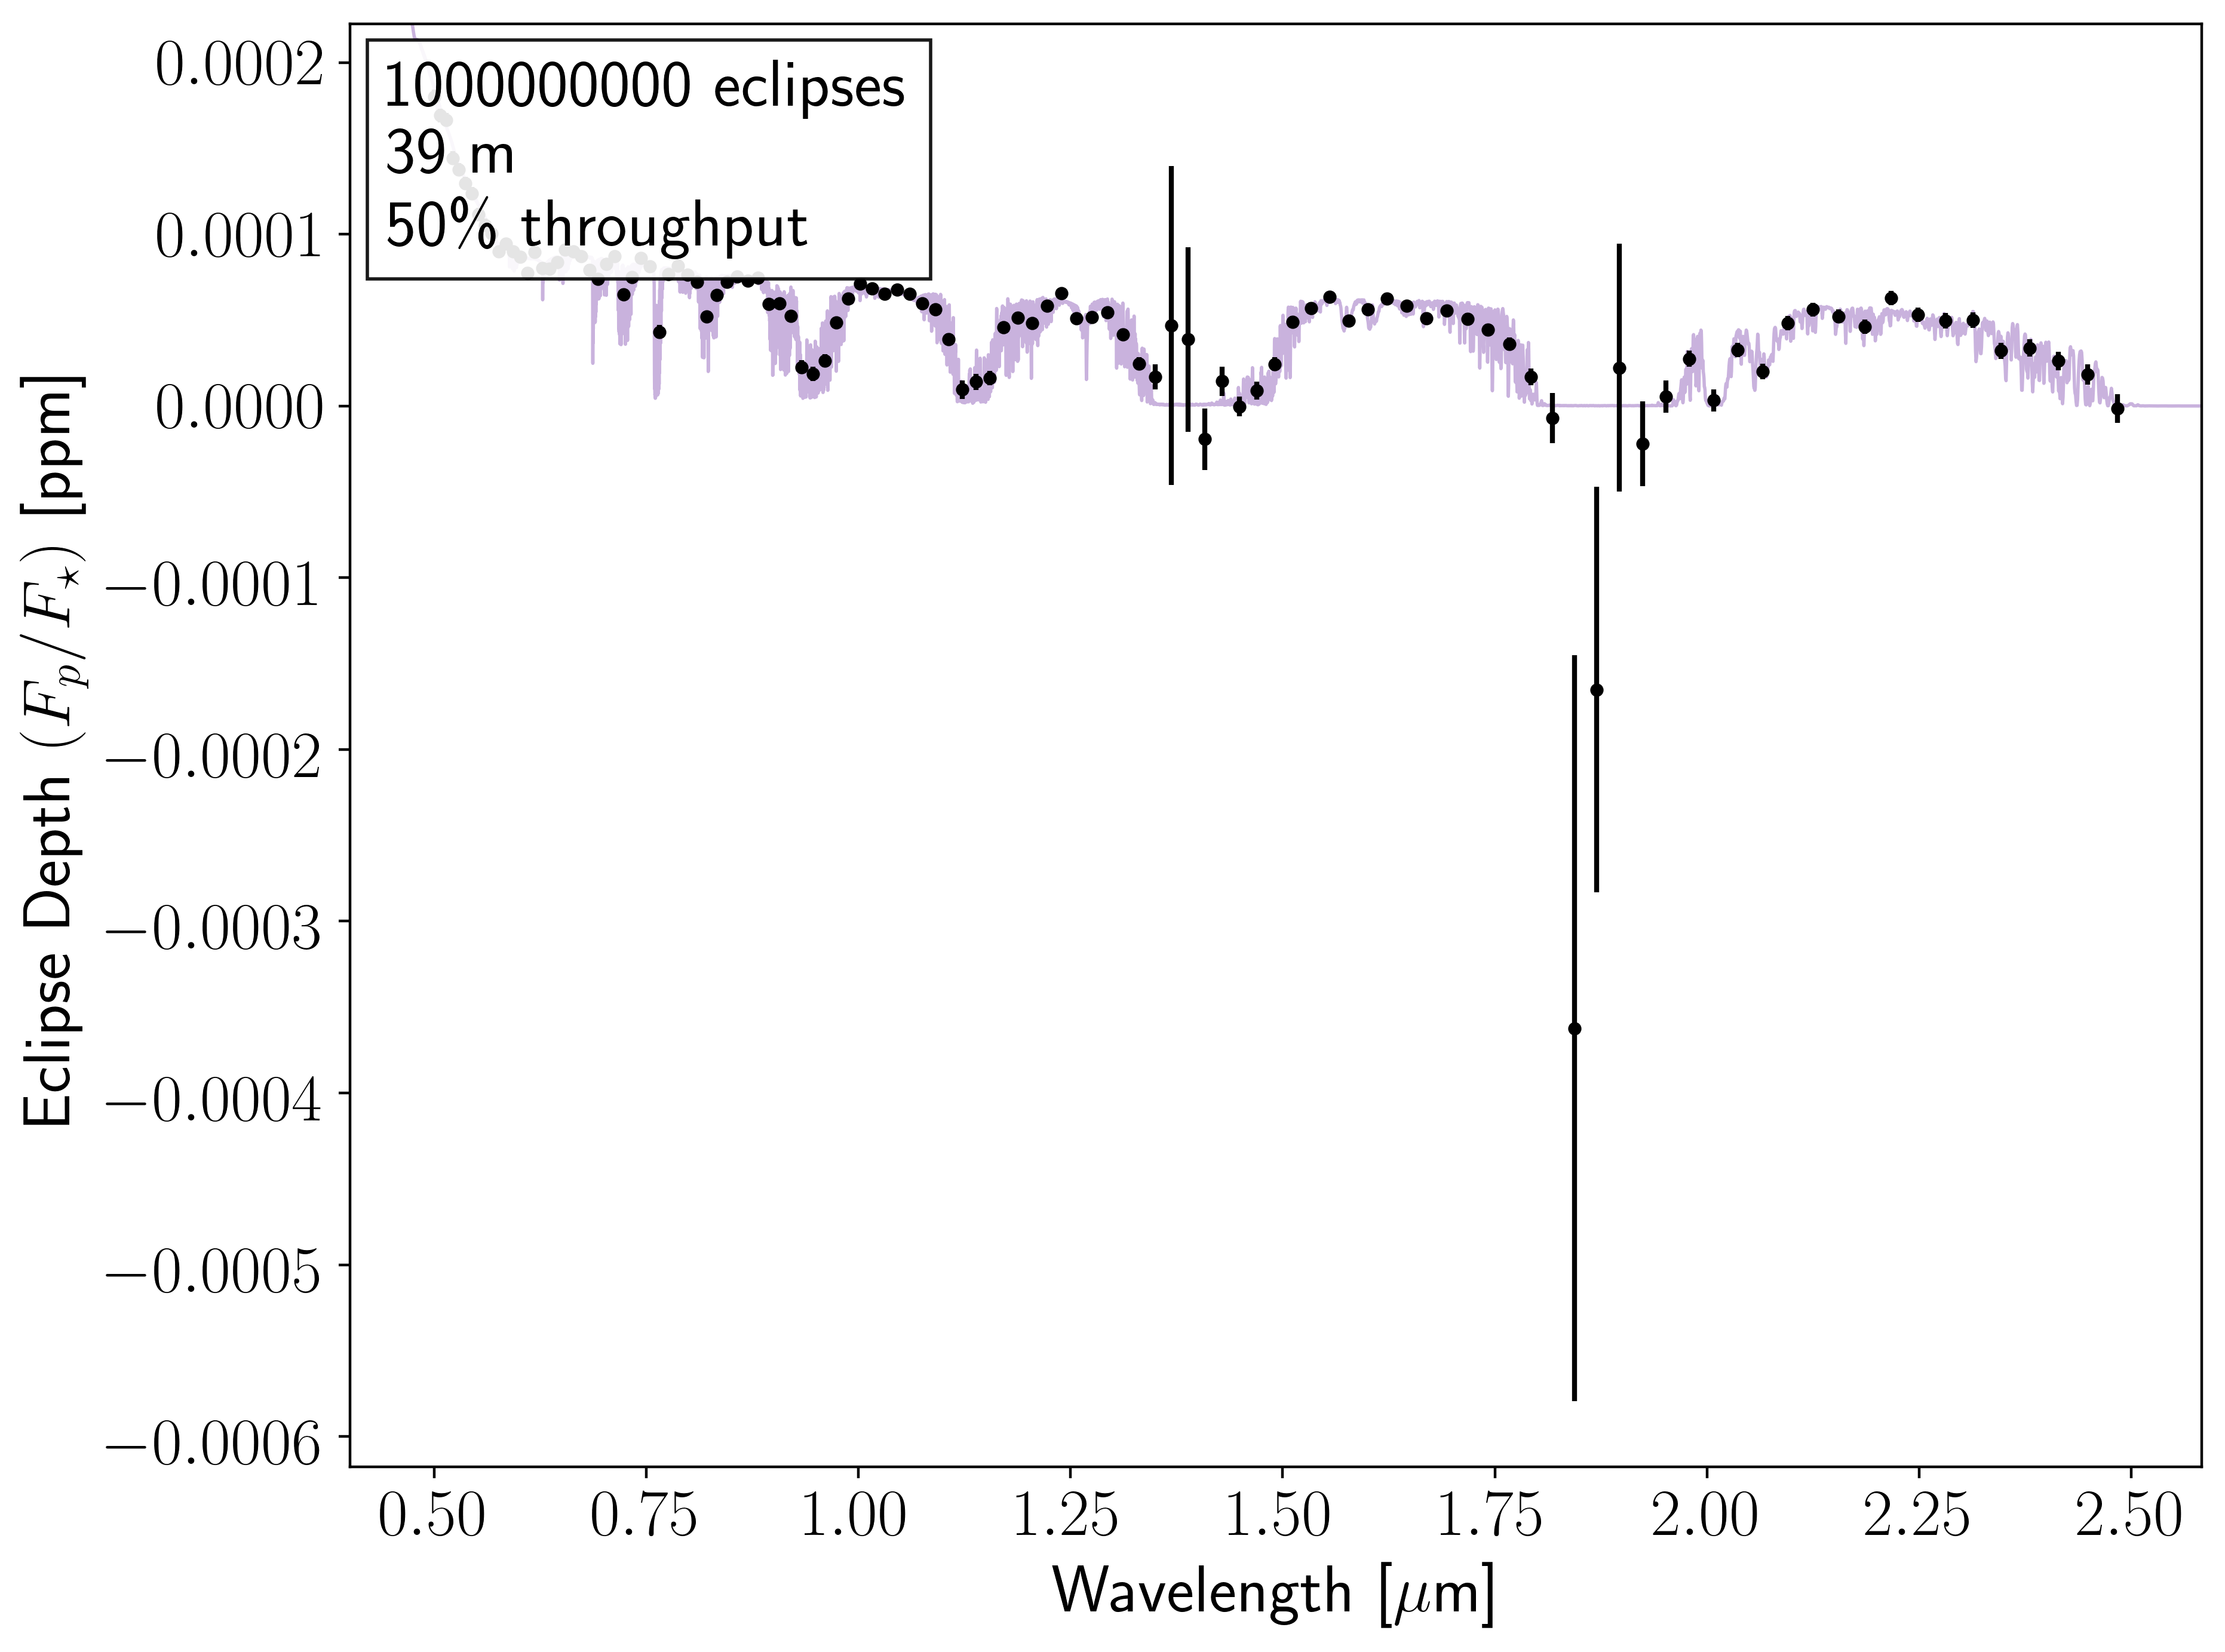

In [23]:
fig, ax = en_sky.plot_spectrum(SNR_threshold=0.0, Nsig=None)

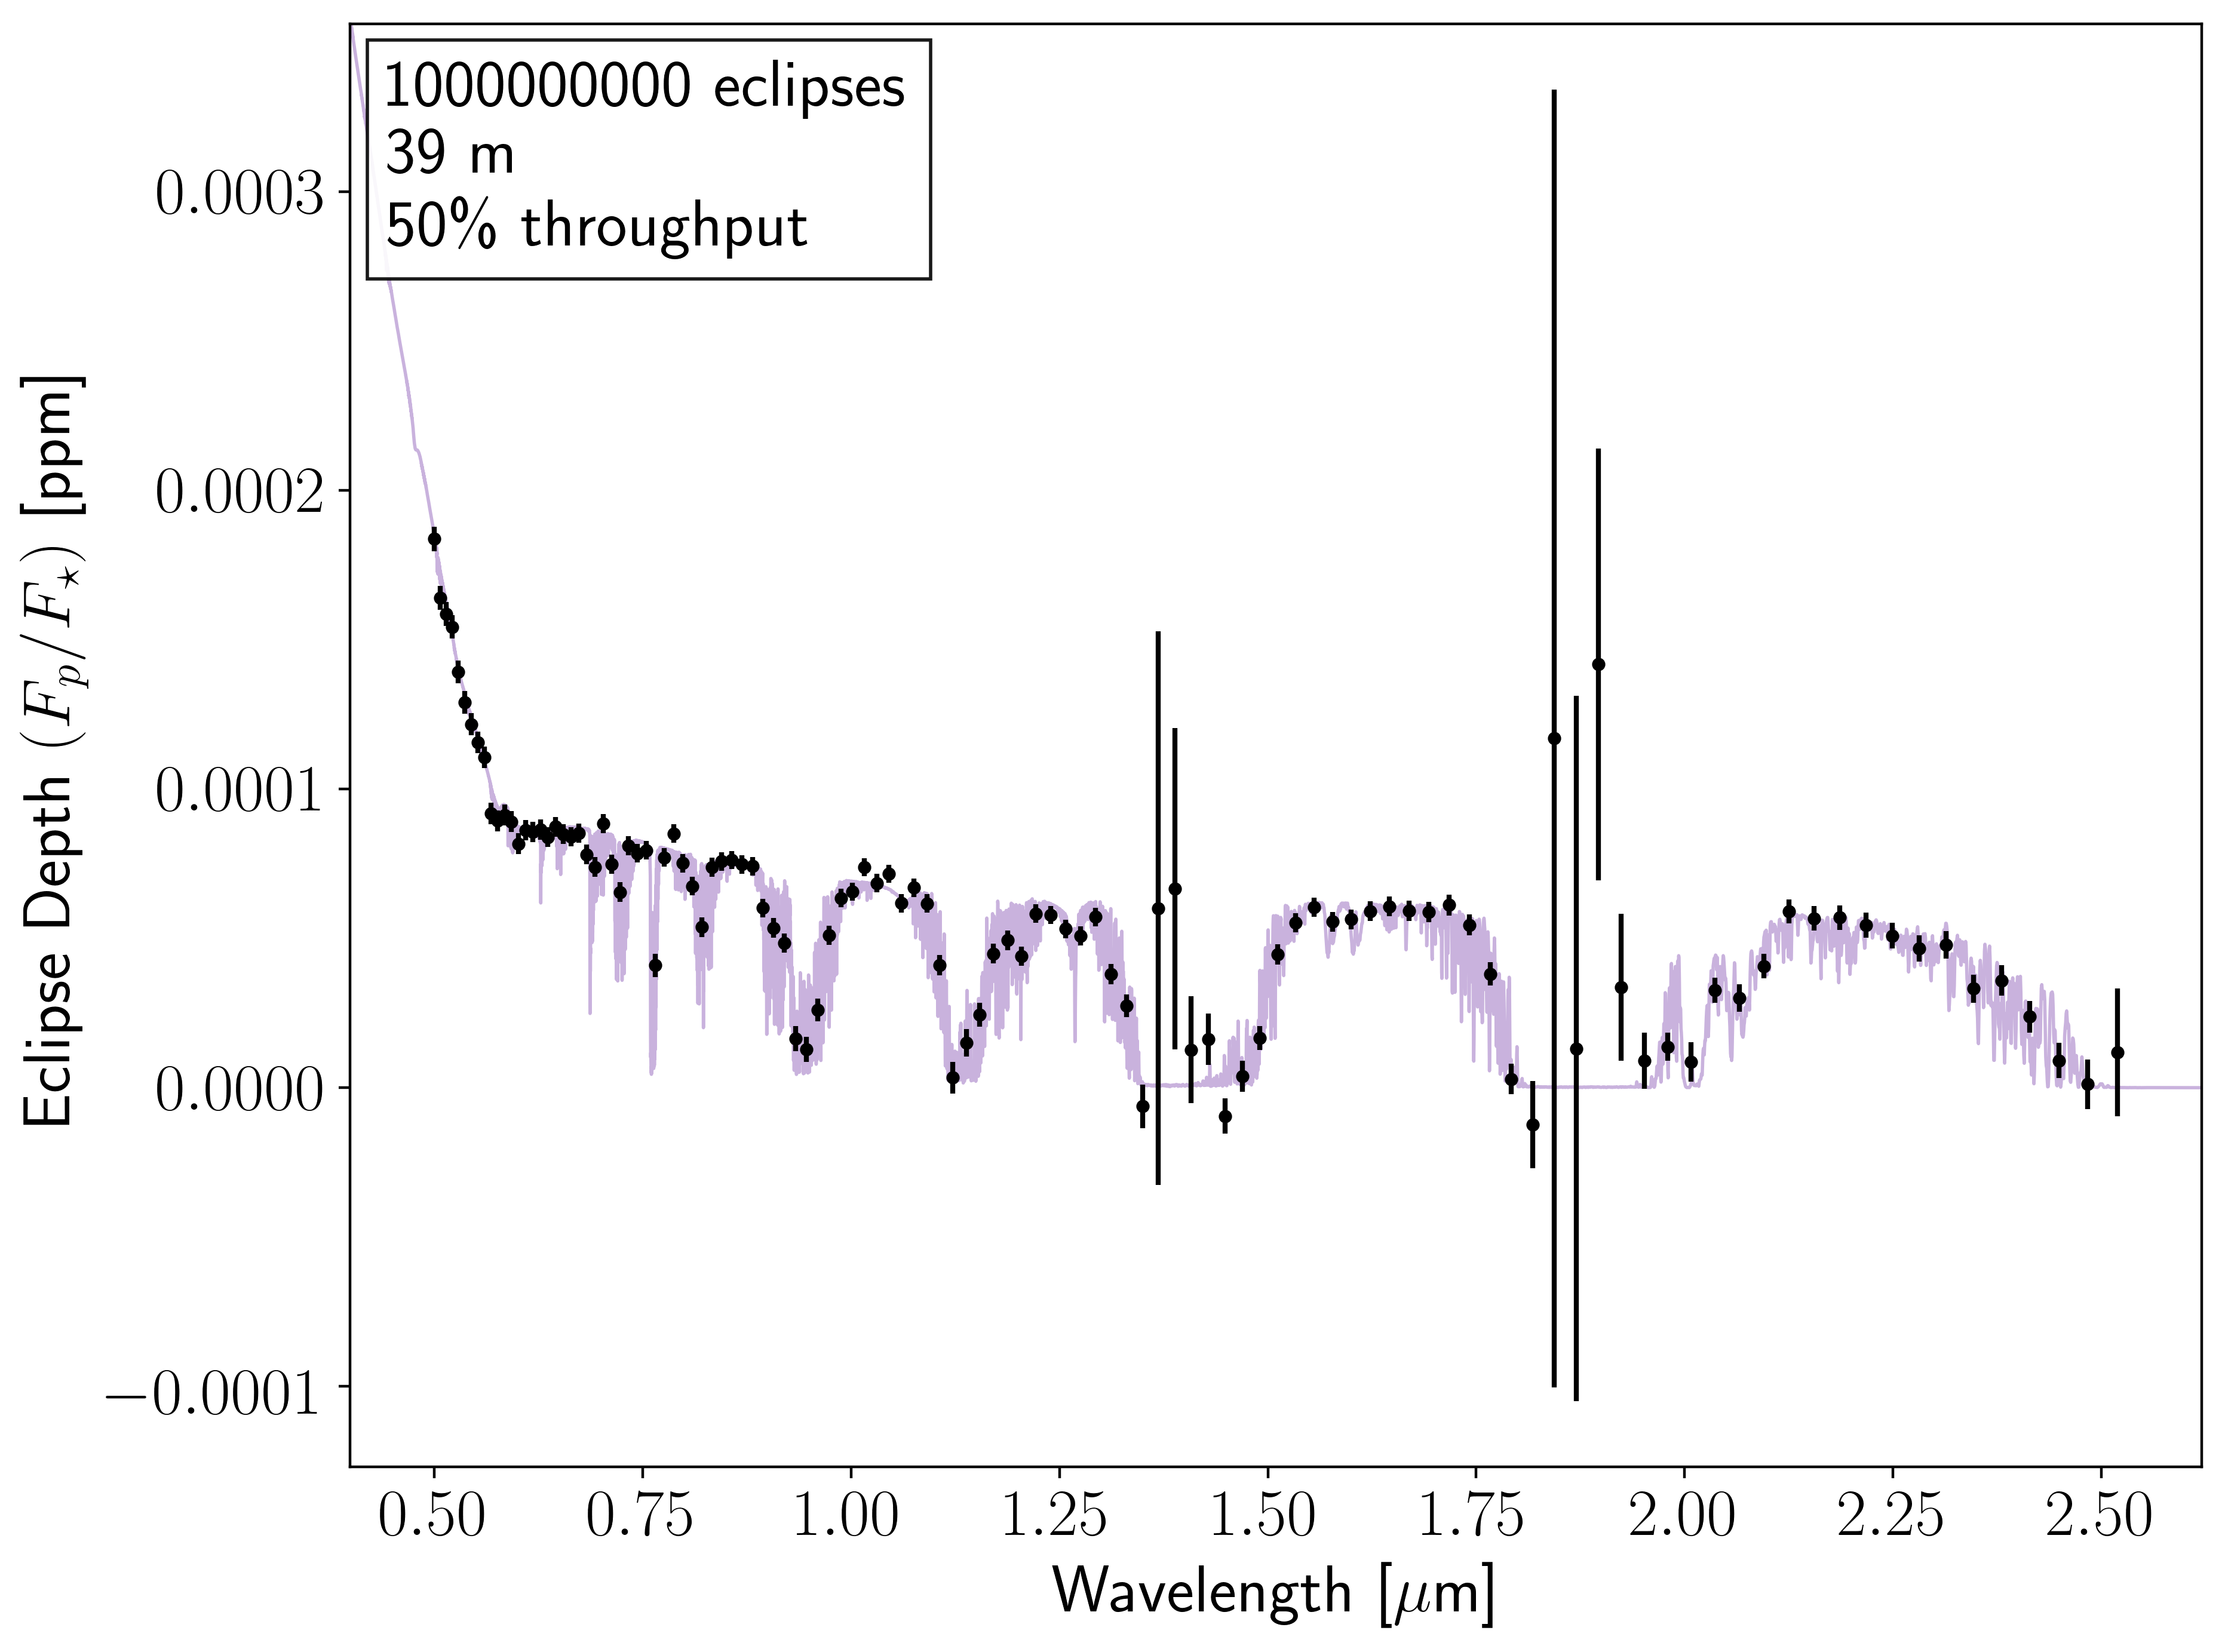

In [24]:
fig, ax = en_sky_orig.plot_spectrum(SNR_threshold=0.0, Nsig=None)

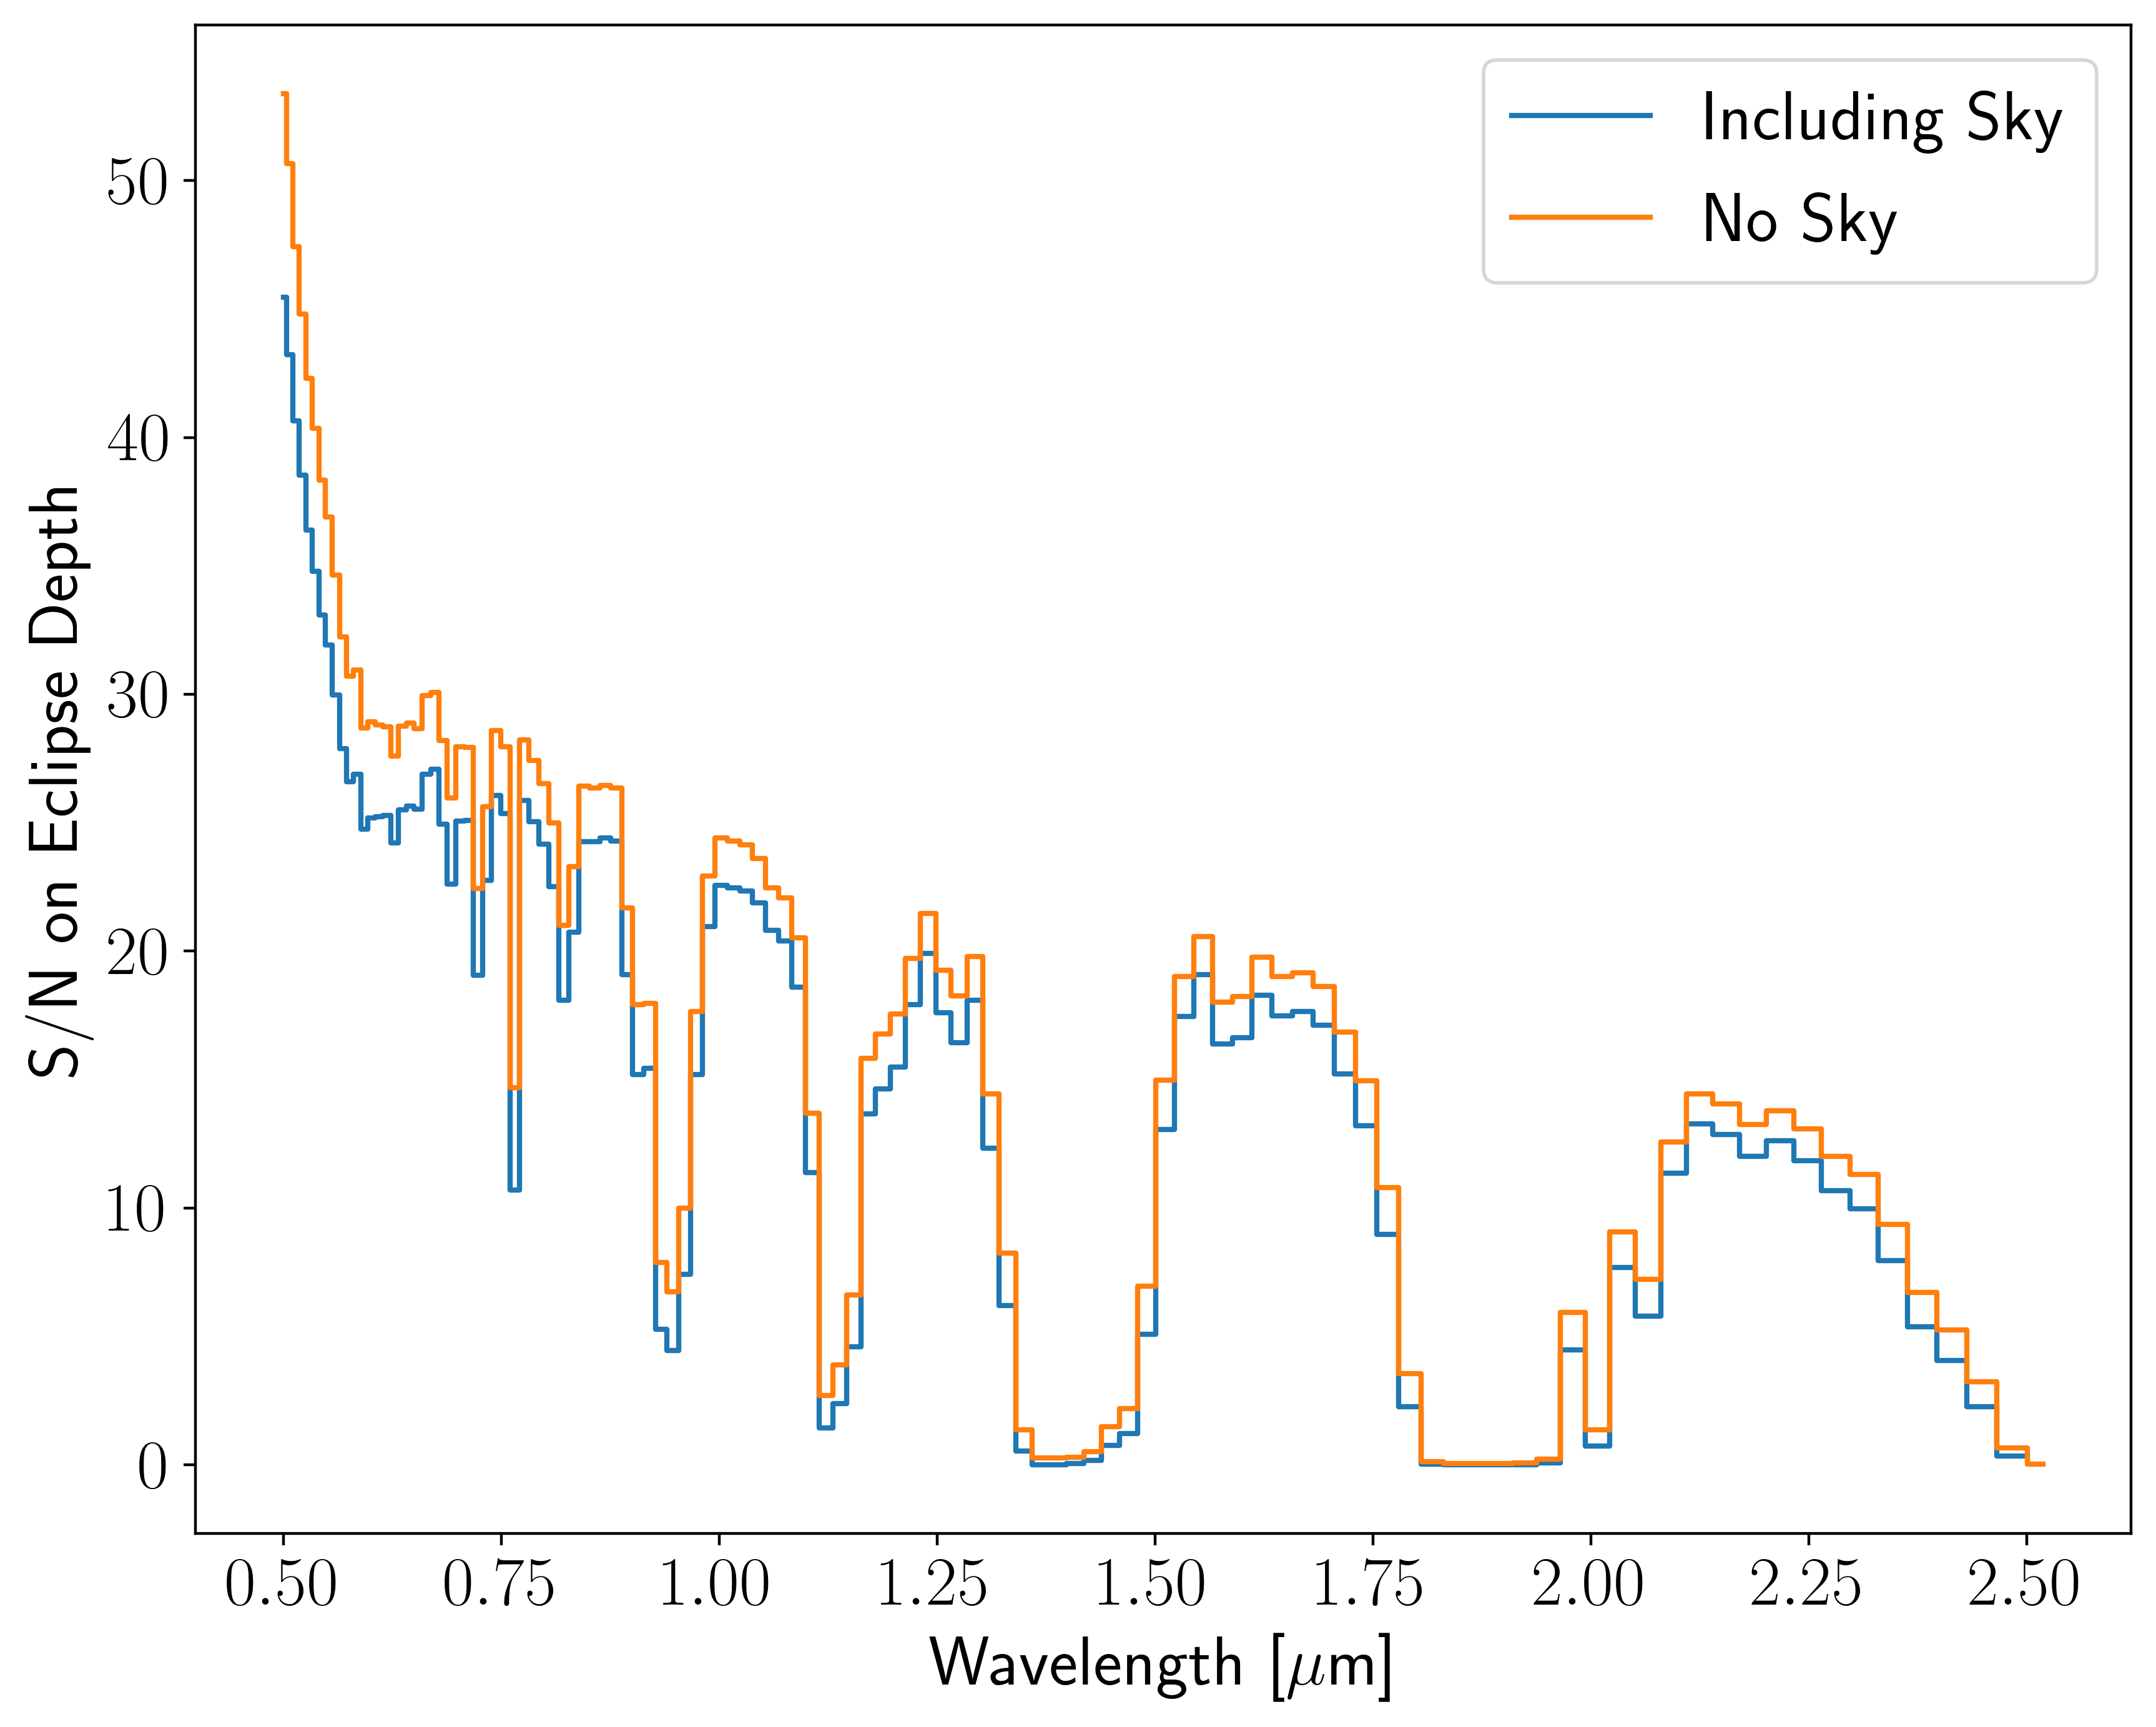

In [77]:
fig, ax = en_sky.plot_SNRn()
en_nosky.plot_SNRn(ax0=ax)
ax.plot(telescope.lammin, 0, color='C0', label='Including Sky')
ax.plot(telescope.lammin, 0, color='C1', label='No Sky')
ax.legend()

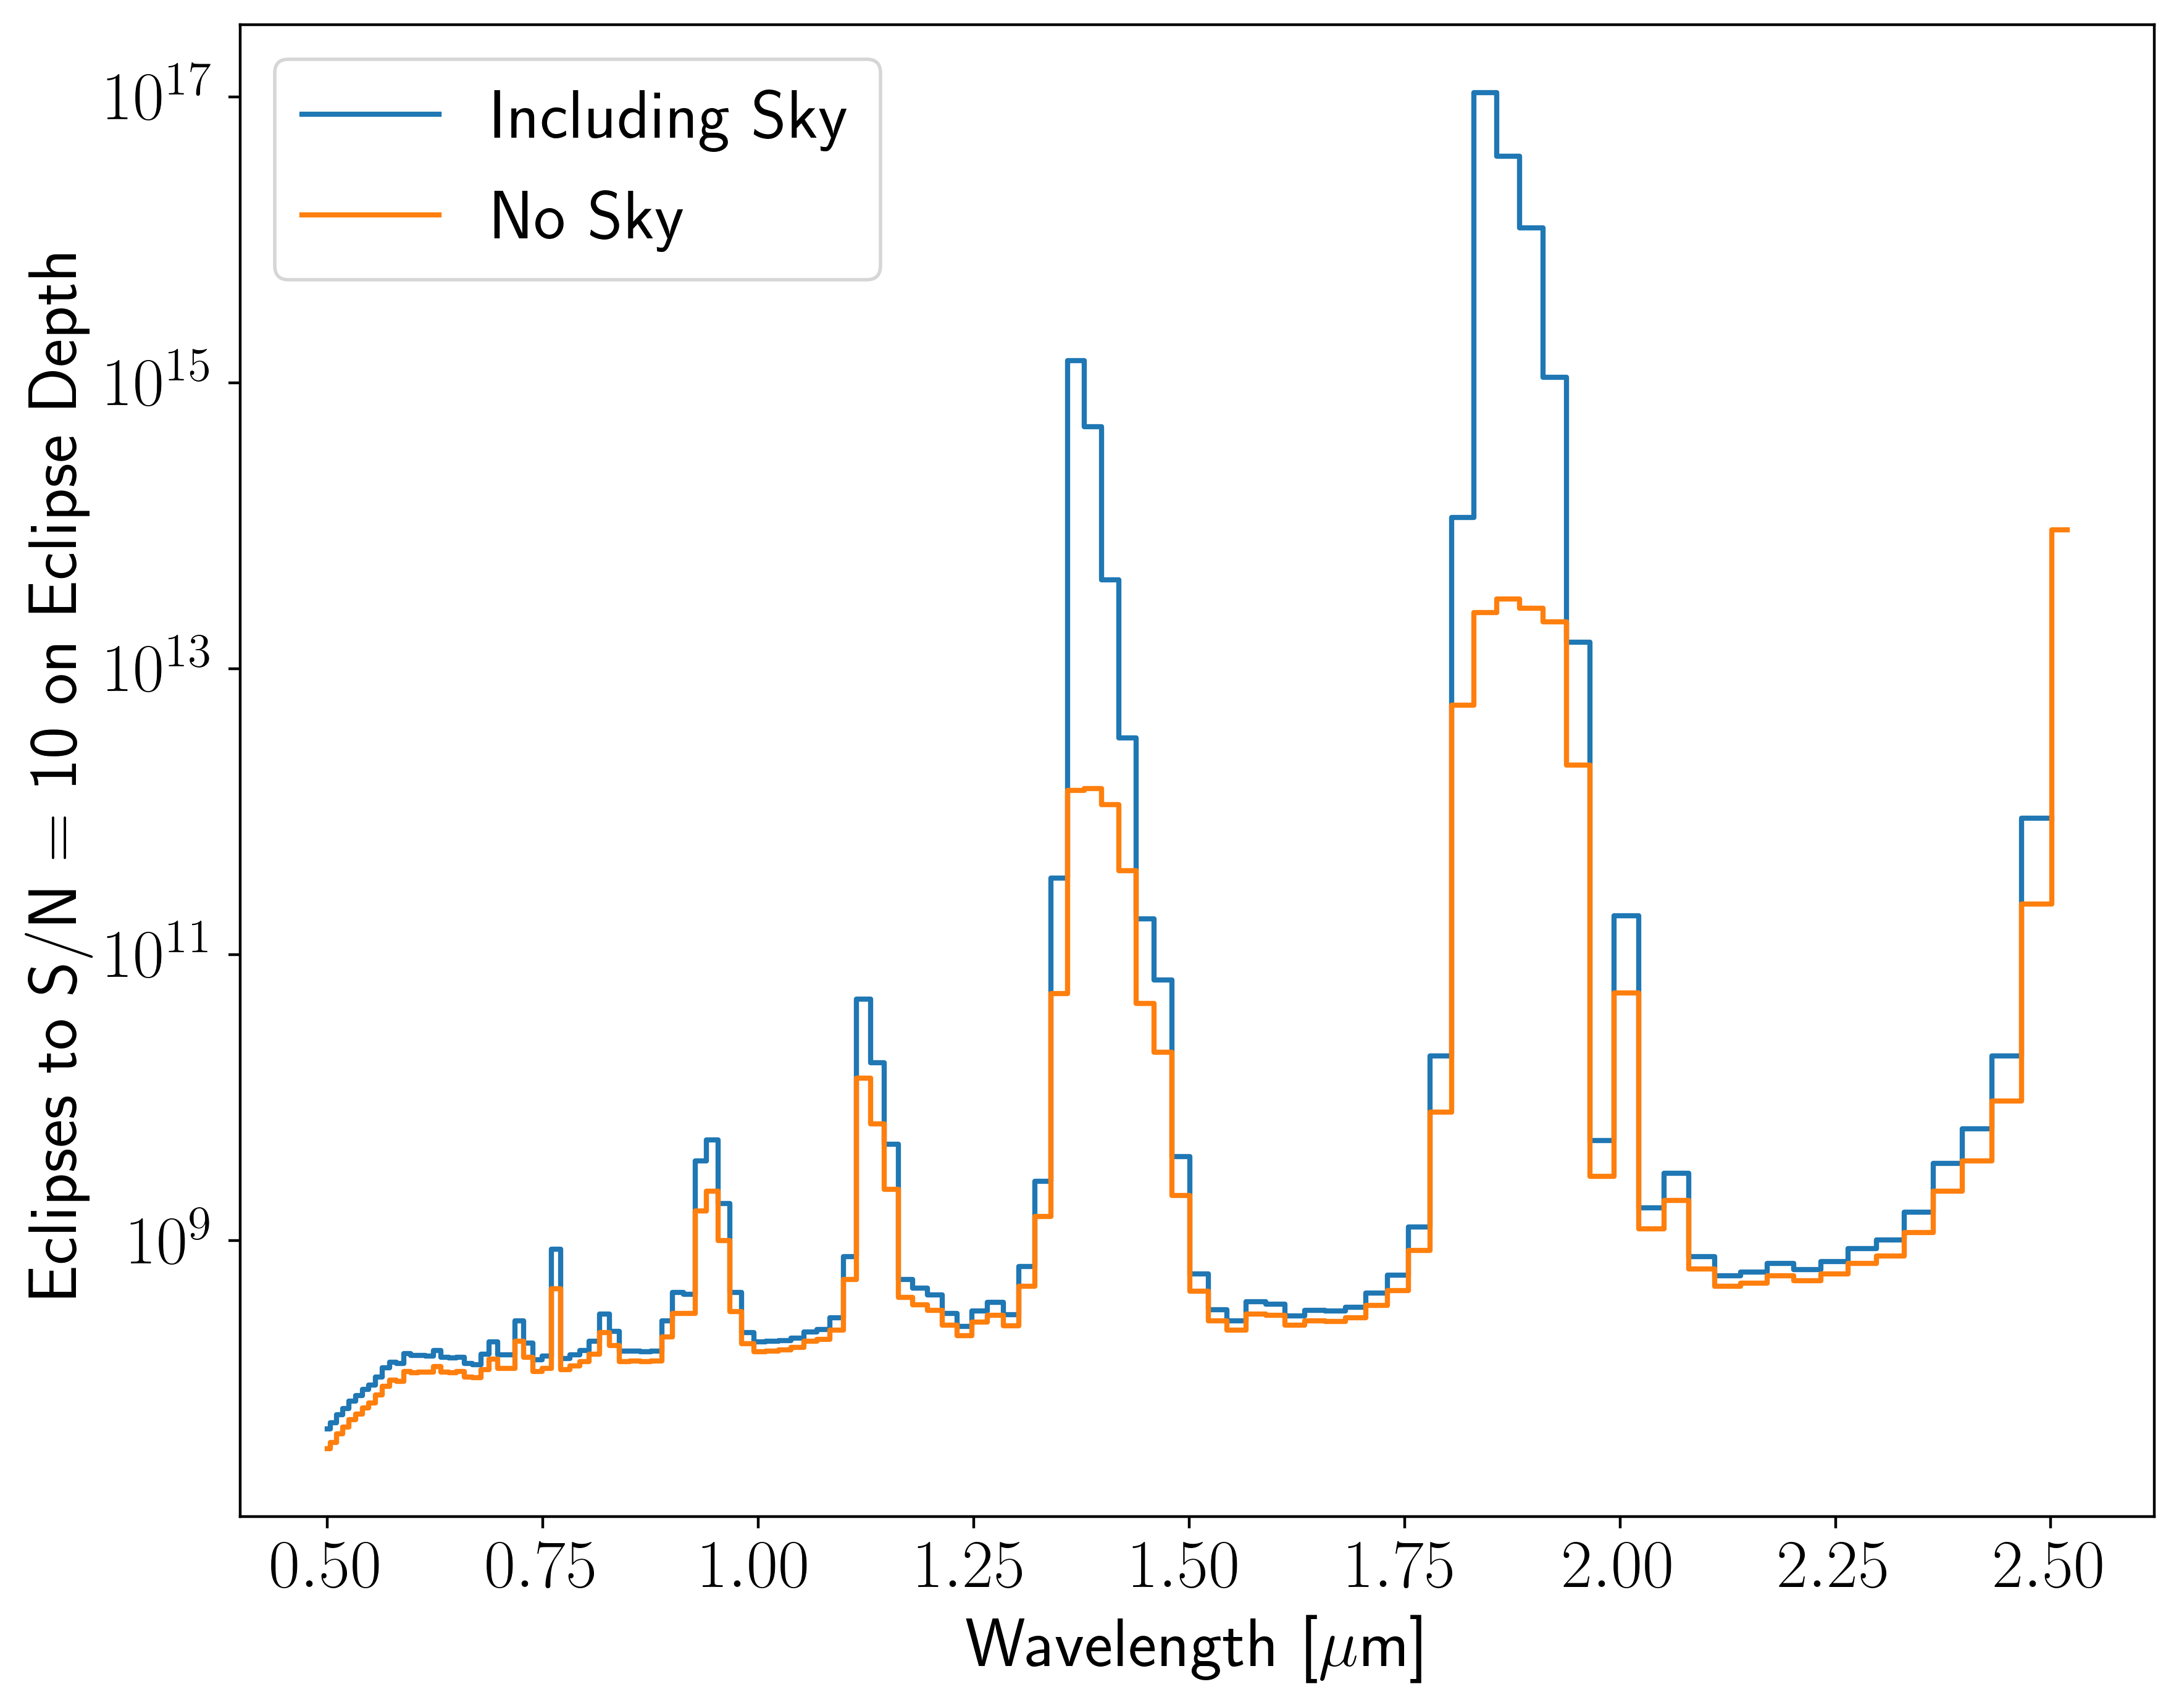

In [78]:
fig, ax = en_sky.plot_ntran_to_wantsnr()
en_nosky.plot_ntran_to_wantsnr(ax0=ax)
ax.plot(telescope.lammin, 0, color='C0', label='Including Sky')
ax.plot(telescope.lammin, 0, color='C1', label='No Sky')
ax.legend()

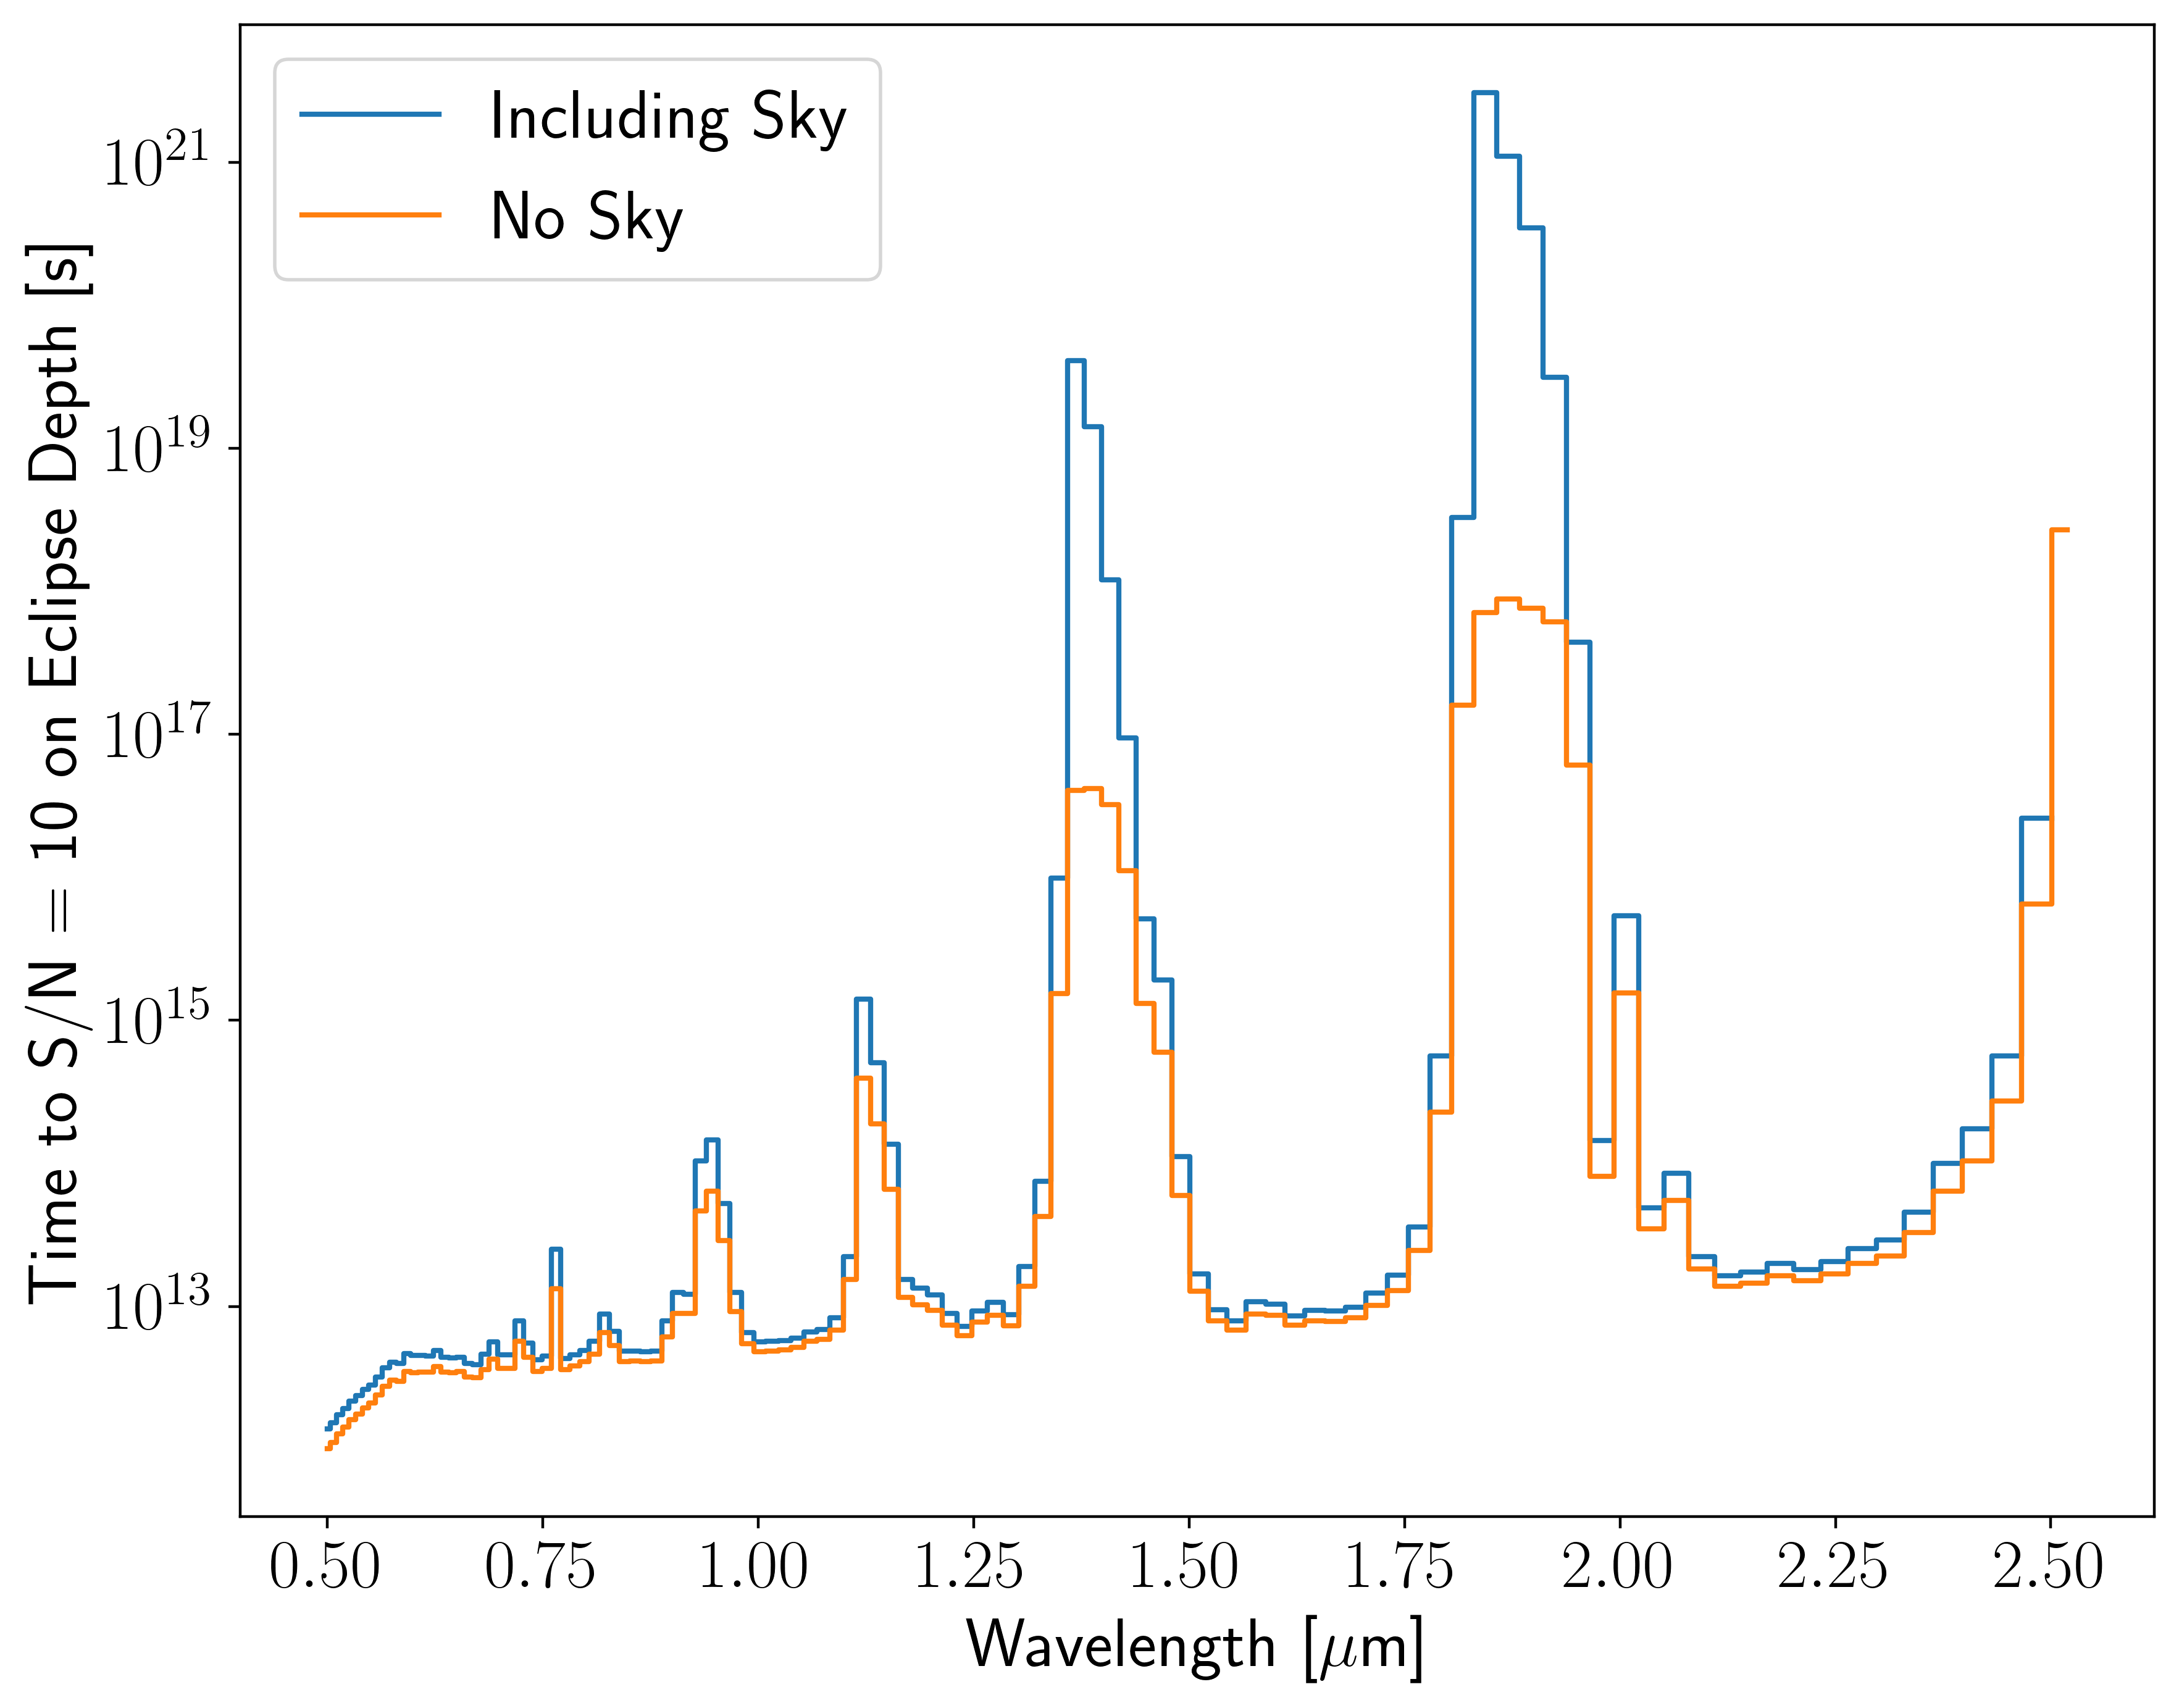

In [79]:
fig, ax = en_sky.plot_time_to_wantsnr()
en_nosky.plot_time_to_wantsnr(ax0=ax)
ax.plot(telescope.lammin, 0, color='C0', label='Including Sky')
ax.plot(telescope.lammin, 0, color='C1', label='No Sky')
ax.legend()

(<Figure size 2000x1600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a233ffdd8>)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


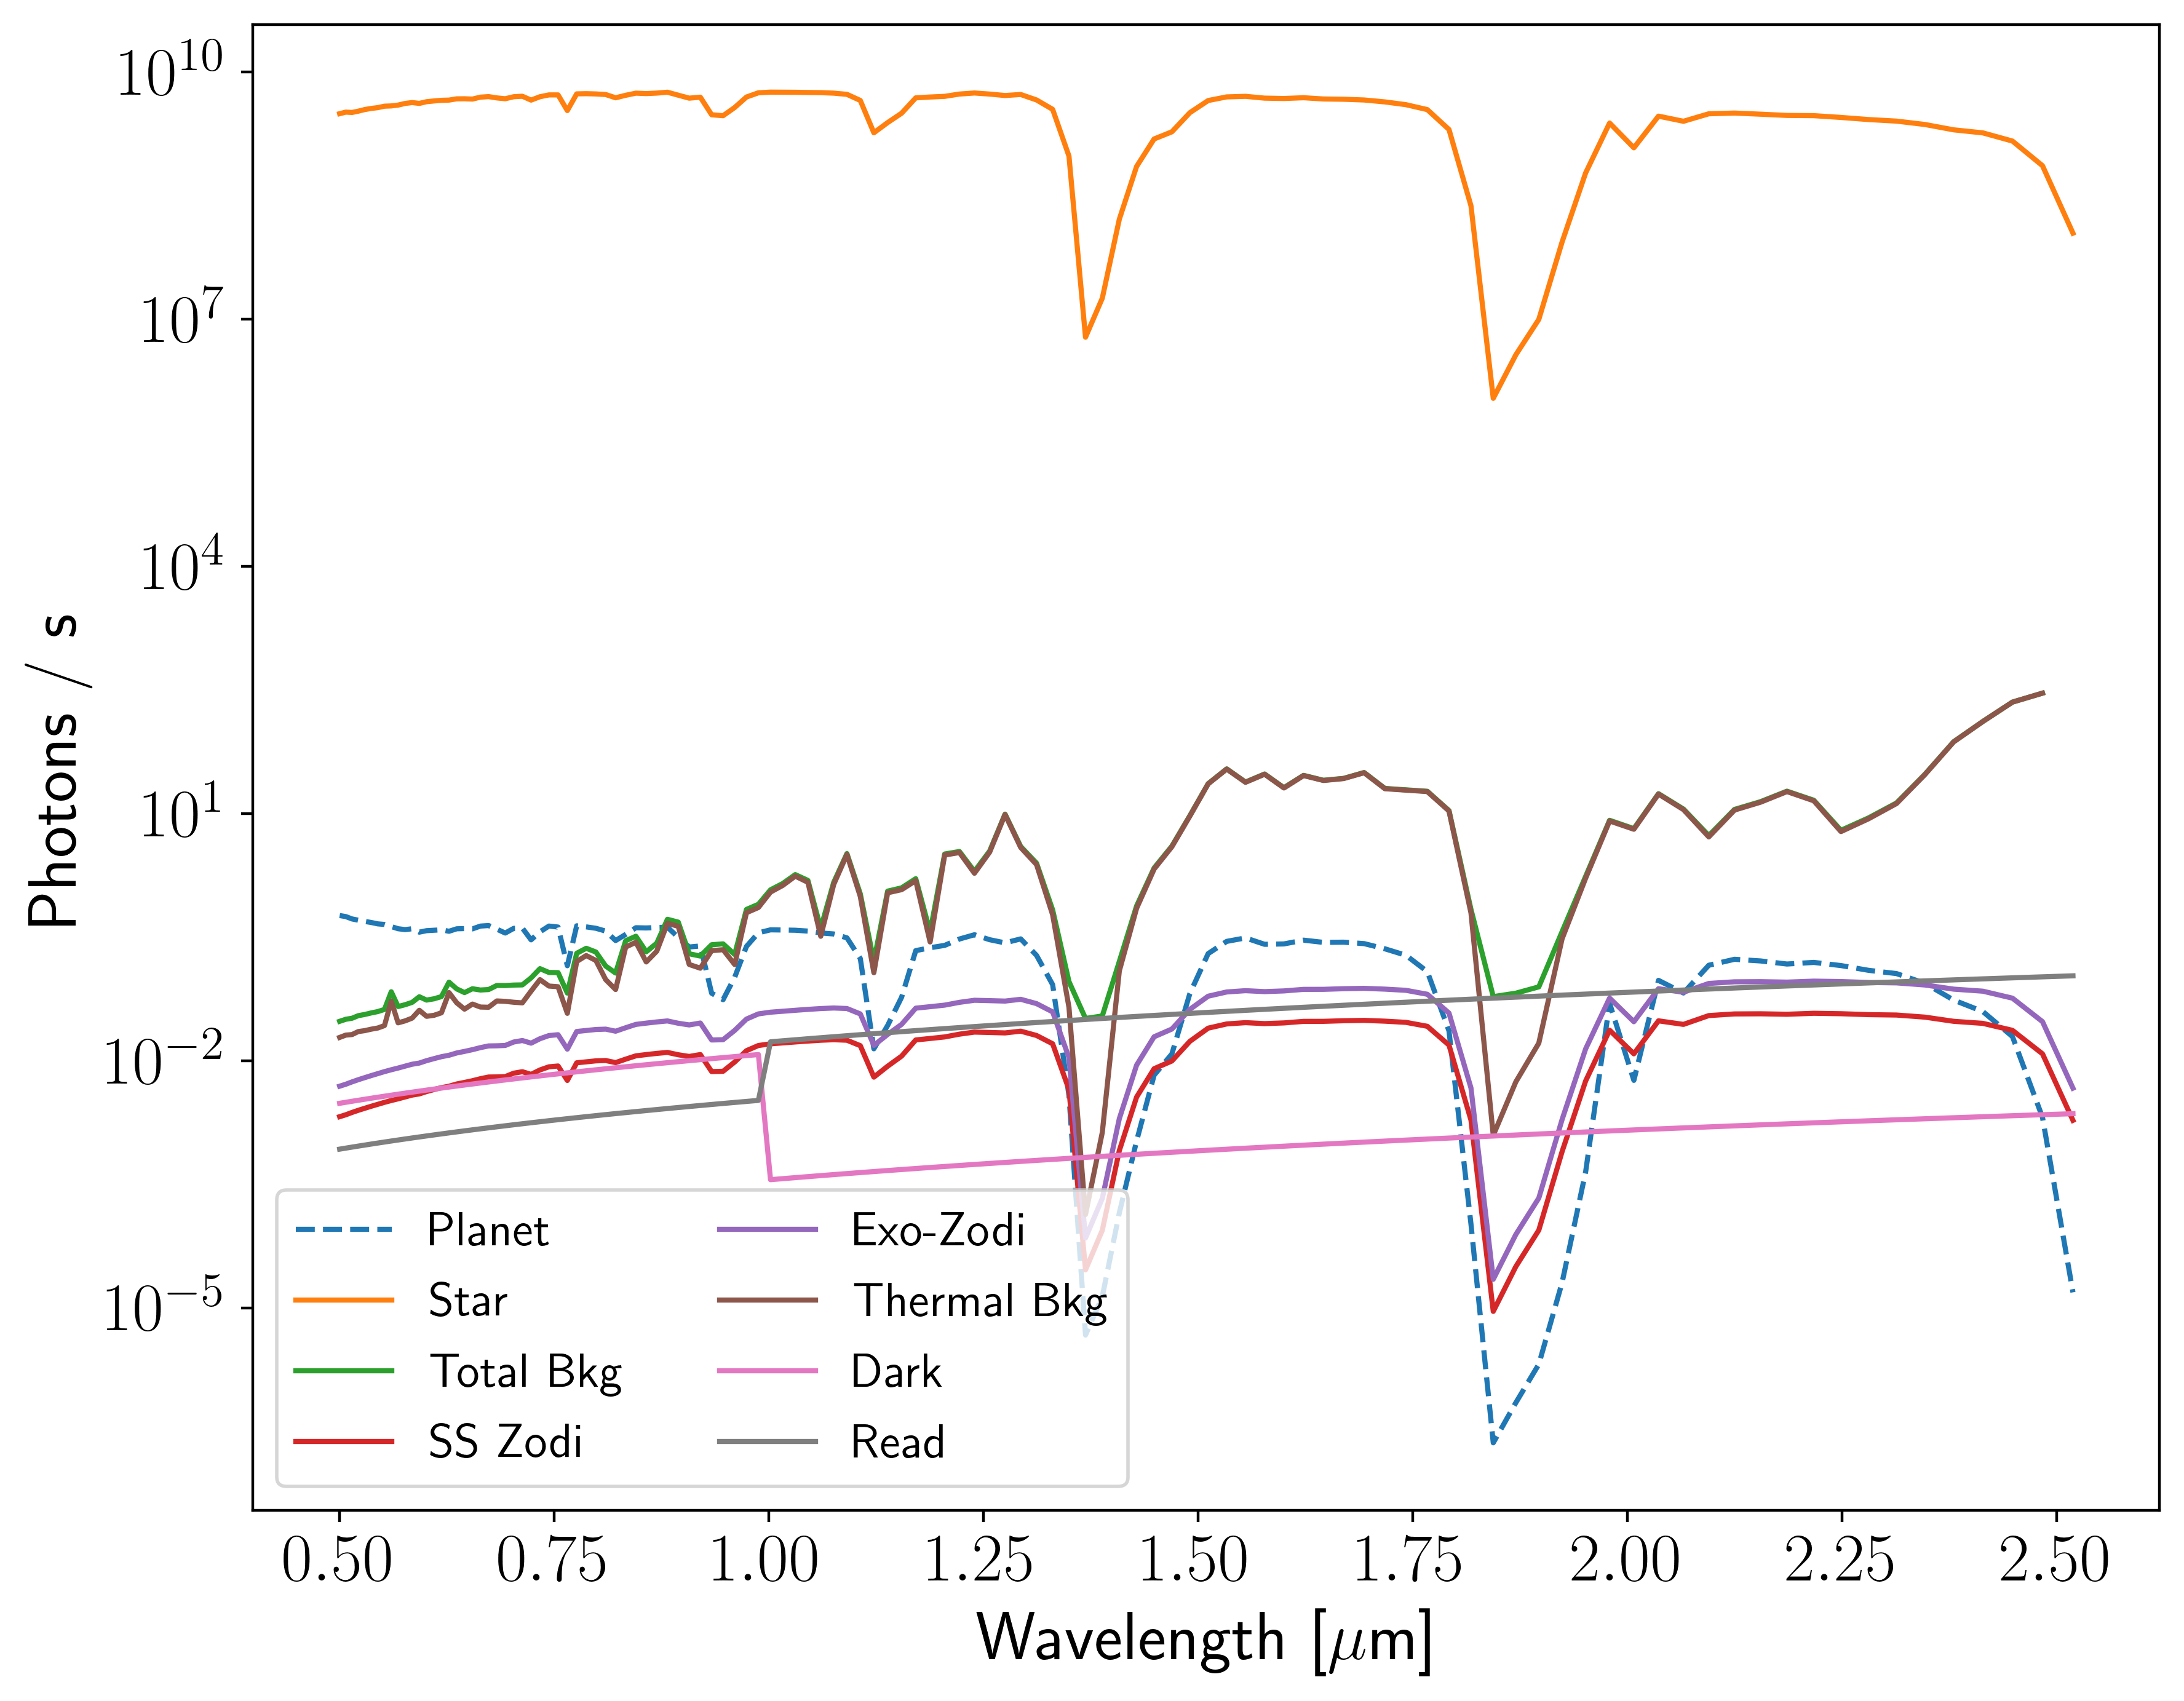

In [43]:
en_sky.plot_count_rates()

# TRANSIT NOISE
The same idea can be applied to transit noise:

In [179]:
tdur = 8.0 * 60 * 60  # Transit/Eclipse duration [seconds]
ntran = 1e3           # Number of eclipses
nout = 2.0            # Number of out-of-eclipse durations [transit durations]
wantsnr = 10.0        # Desired S/N per resolution element (when applicable)

In [180]:
telescope = cg.Telescope(Tput = 0.5,      # Throughput
                         D = 39.,         # Diameter [m]
                         R = 70,          # Resolving power (lam / dlam)
                         lammin  = 5,   # Minimum Wavelength [um]
                         lammax  = 20,  # Maximum Wavelength [um]
                         Tsys = 0.0,      # Telescope mirror temperature [K]
                        )  

In [181]:
planet = cg.Planet(a = 1.0,   # Semi-major axis [AU]
                   d = 10.0,  # Distance [pc]
                   Rp = 1.0   # Planet Radius [Earth Radii]
                  )

star = cg.Star(Rs = 1.0,      # Stellar Radius [Solar Radii]
               Teff = 5700.   # Stellar Effective Temperature [K]
              )

In [182]:
skyflux = cg.SkyFlux()
skyflux.wmin = telescope.lammin * 1000
skyflux.wmax = telescope.lammax * 1000
print(skyflux)

Sky Flux: 
---------
- Airmass : 1.0
- PWV Mode : pwv
- Season  : 0
- Time of Night  : 0 
- Precipitable Water Vapor (PWV) [mm]  : 3.5 
- Monthly Averaged Solar Flux [sfu=0.01 MJy]  : 130.0 
- Include Scattered Moonlight?  : Y 
- Separation of Sun and Moon as seen from Earth [deg] : 90.0 
- Separation of Moon and target [deg]  : 45.0 
- Moon altitude over horizon  : 45.0 
- Moon-Earth distance (mean=1)  : 1.0 
- Include scattered starlight?  : Y 
- Include zodiacal light?  : Y 
- Heliocentric ecliptic longitude [deg]  : 135.0 
- Ecliptic latitude [deg]  : 90.0 
- Include molecular emission of lower atmosphere?  : Y 
- Include molecular emission of upper atmosphere?  : Y 
- Include upper airglow continuum?  : Y 
- Include instrumental thermal radiation?  : N 
- Instrumental temperature 1  : 0.0 
- Instrumental emmisivity 1  : 0.0 
- Instrumental temperature 2  : 0.0 
- Instrumental emmisivity 2  : 0.0 
- Instrumental temperature 3  : 0.0 
- Instrumental emmisivity 3  : 0.0 
- Calculatio

In [183]:
skyflux.run_skycalc('./testing.fits')

RUNNING: skycalc_cli -i .//skycalc_params.txt -o ./testing.fits -a .//almanac_params.txt
DONE


In [184]:
lam, tdepth, fplan, fstar = cg.get_earth_trans_spectrum()

In [187]:
tn_nosky = cg.TransitNoise(tdur = tdur,            # Transit Duration
                          telescope = telescope,  # Telescope object
                          planet = planet,        # Planet object
                          star = star,            # Star object
                          ntran = ntran,          # Number of eclipses to observe
                          nout = nout,            # Number of out-of-eclipse observing
                          wantsnr = wantsnr)      # Desired S/N per resolution element (when applicable)

tn_sky = cg.TransitNoise(tdur = tdur,            # Transit Duration
                          telescope = telescope,  # Telescope object
                          planet = planet,        # Planet object
                          star = star,            # Star object
                          skyflux = skyflux,
                          ntran = ntran,          # Number of eclipses to observe
                          nout = nout,            # Number of out-of-eclipse observing
                          wantsnr = wantsnr,      # Desired S/N per resolution element (when applicable)
                          GROUND = 'SKYFLUX')

Remember to pass `tepth` to `run_count_rates()` instead of `fplan`.

In [188]:
tn_nosky.run_count_rates(lam, tdepth, fstar)
tn_sky.run_count_rates(lam, tdepth, fstar)

(83, 87)

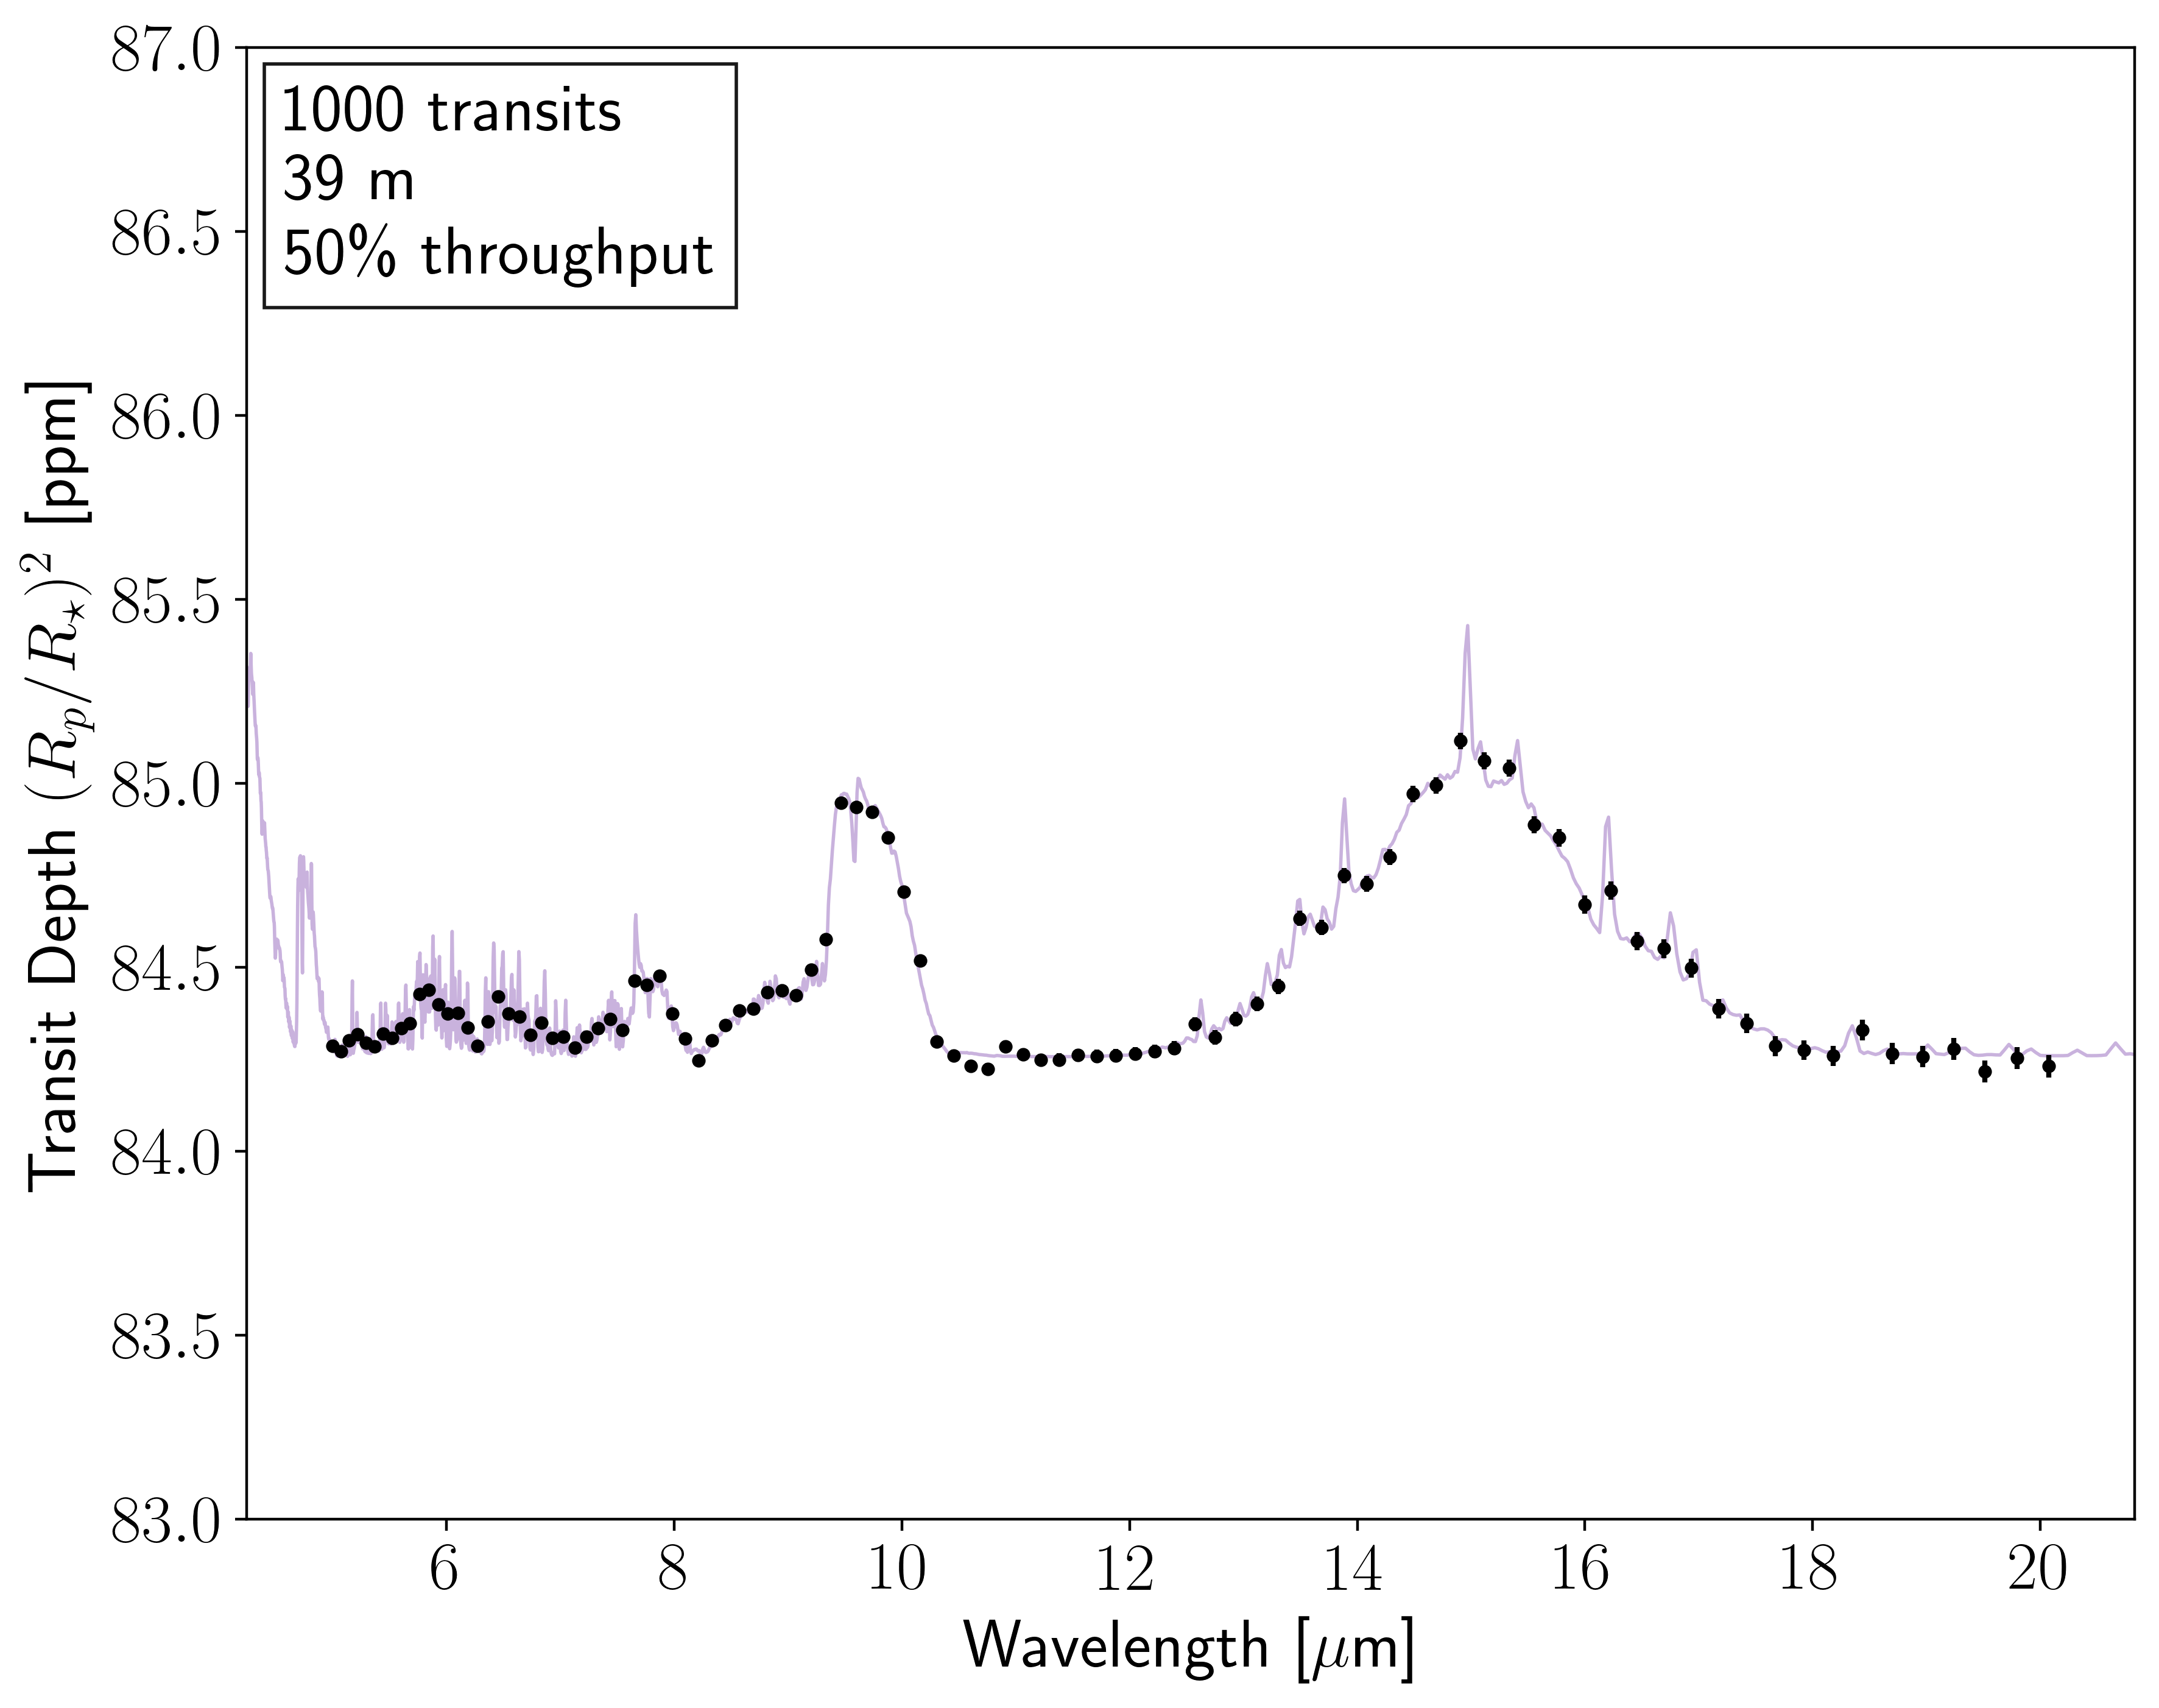

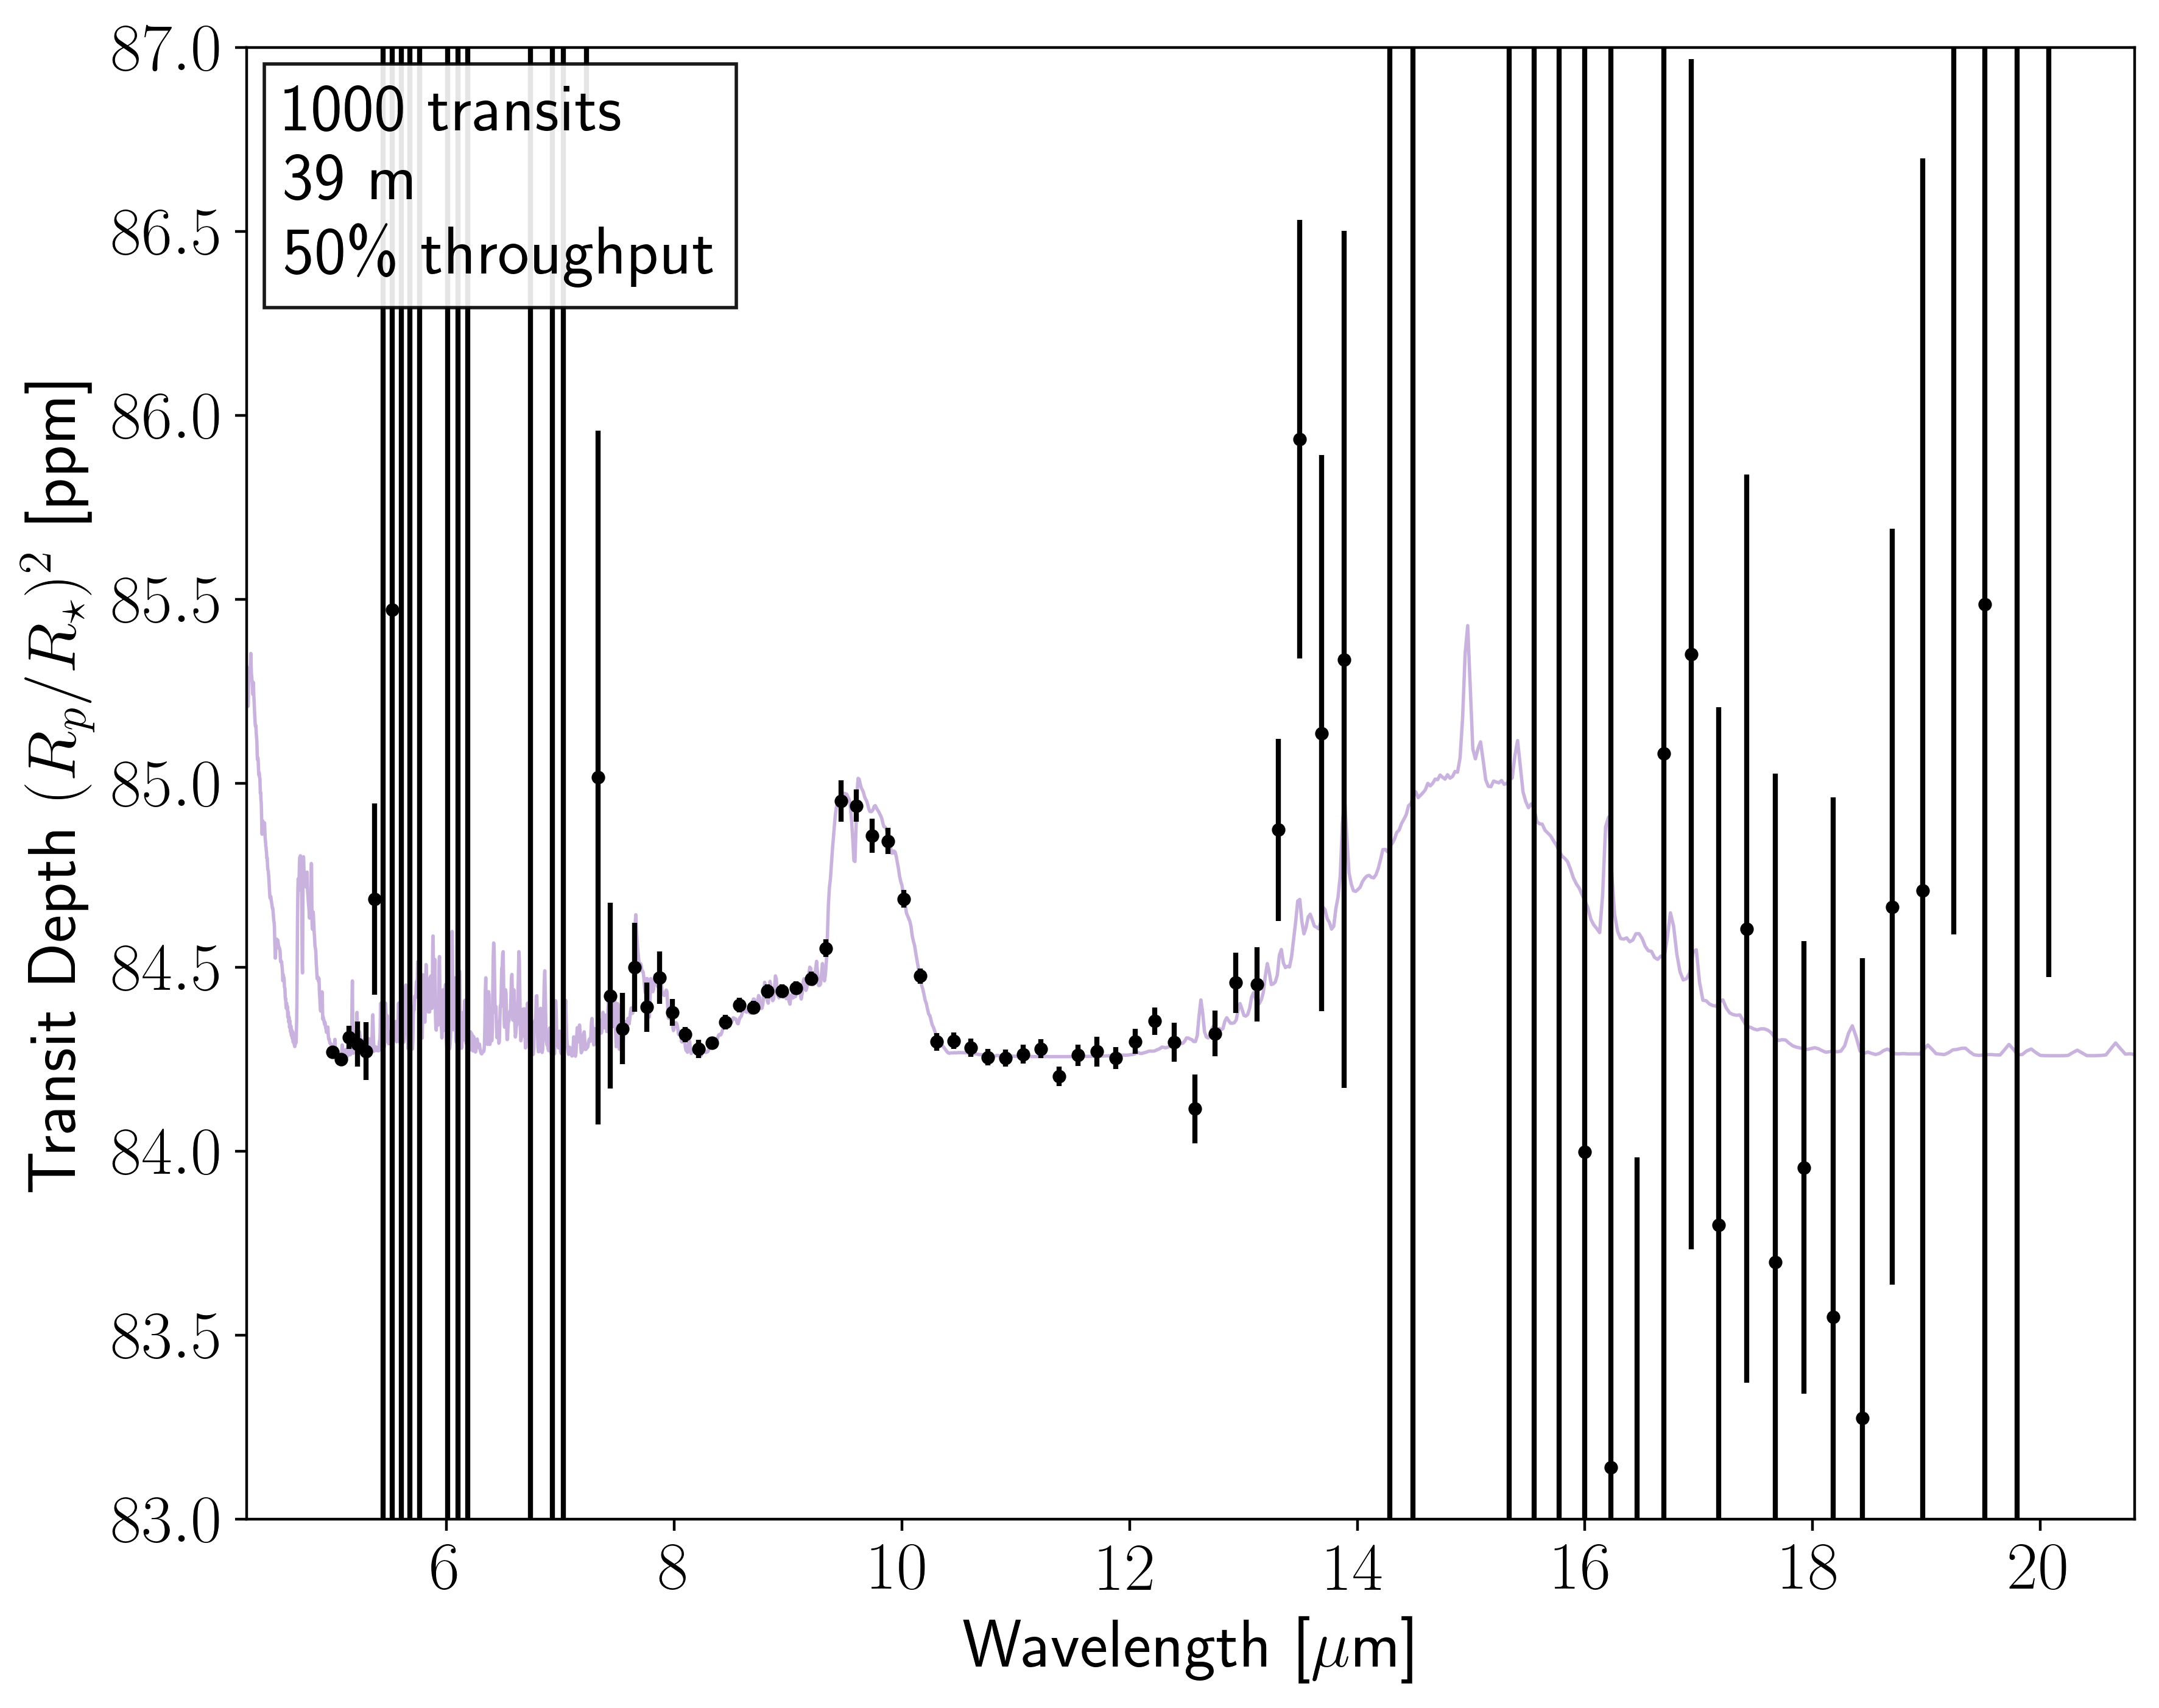

In [189]:
fig, ax = tn_nosky.plot_spectrum(SNR_threshold=0.0, Nsig = 15)
ax.set_ylim(83, 87)
fig, ax = tn_sky.plot_spectrum(SNR_threshold=0.0, Nsig = 15)
ax.set_ylim(83, 87)

The large errors are due to the noise introduced by the atmosphere. The photon count rates and S/N also decrease in these areas due to this effect:

(<Figure size 2000x1600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a50c7e780>)

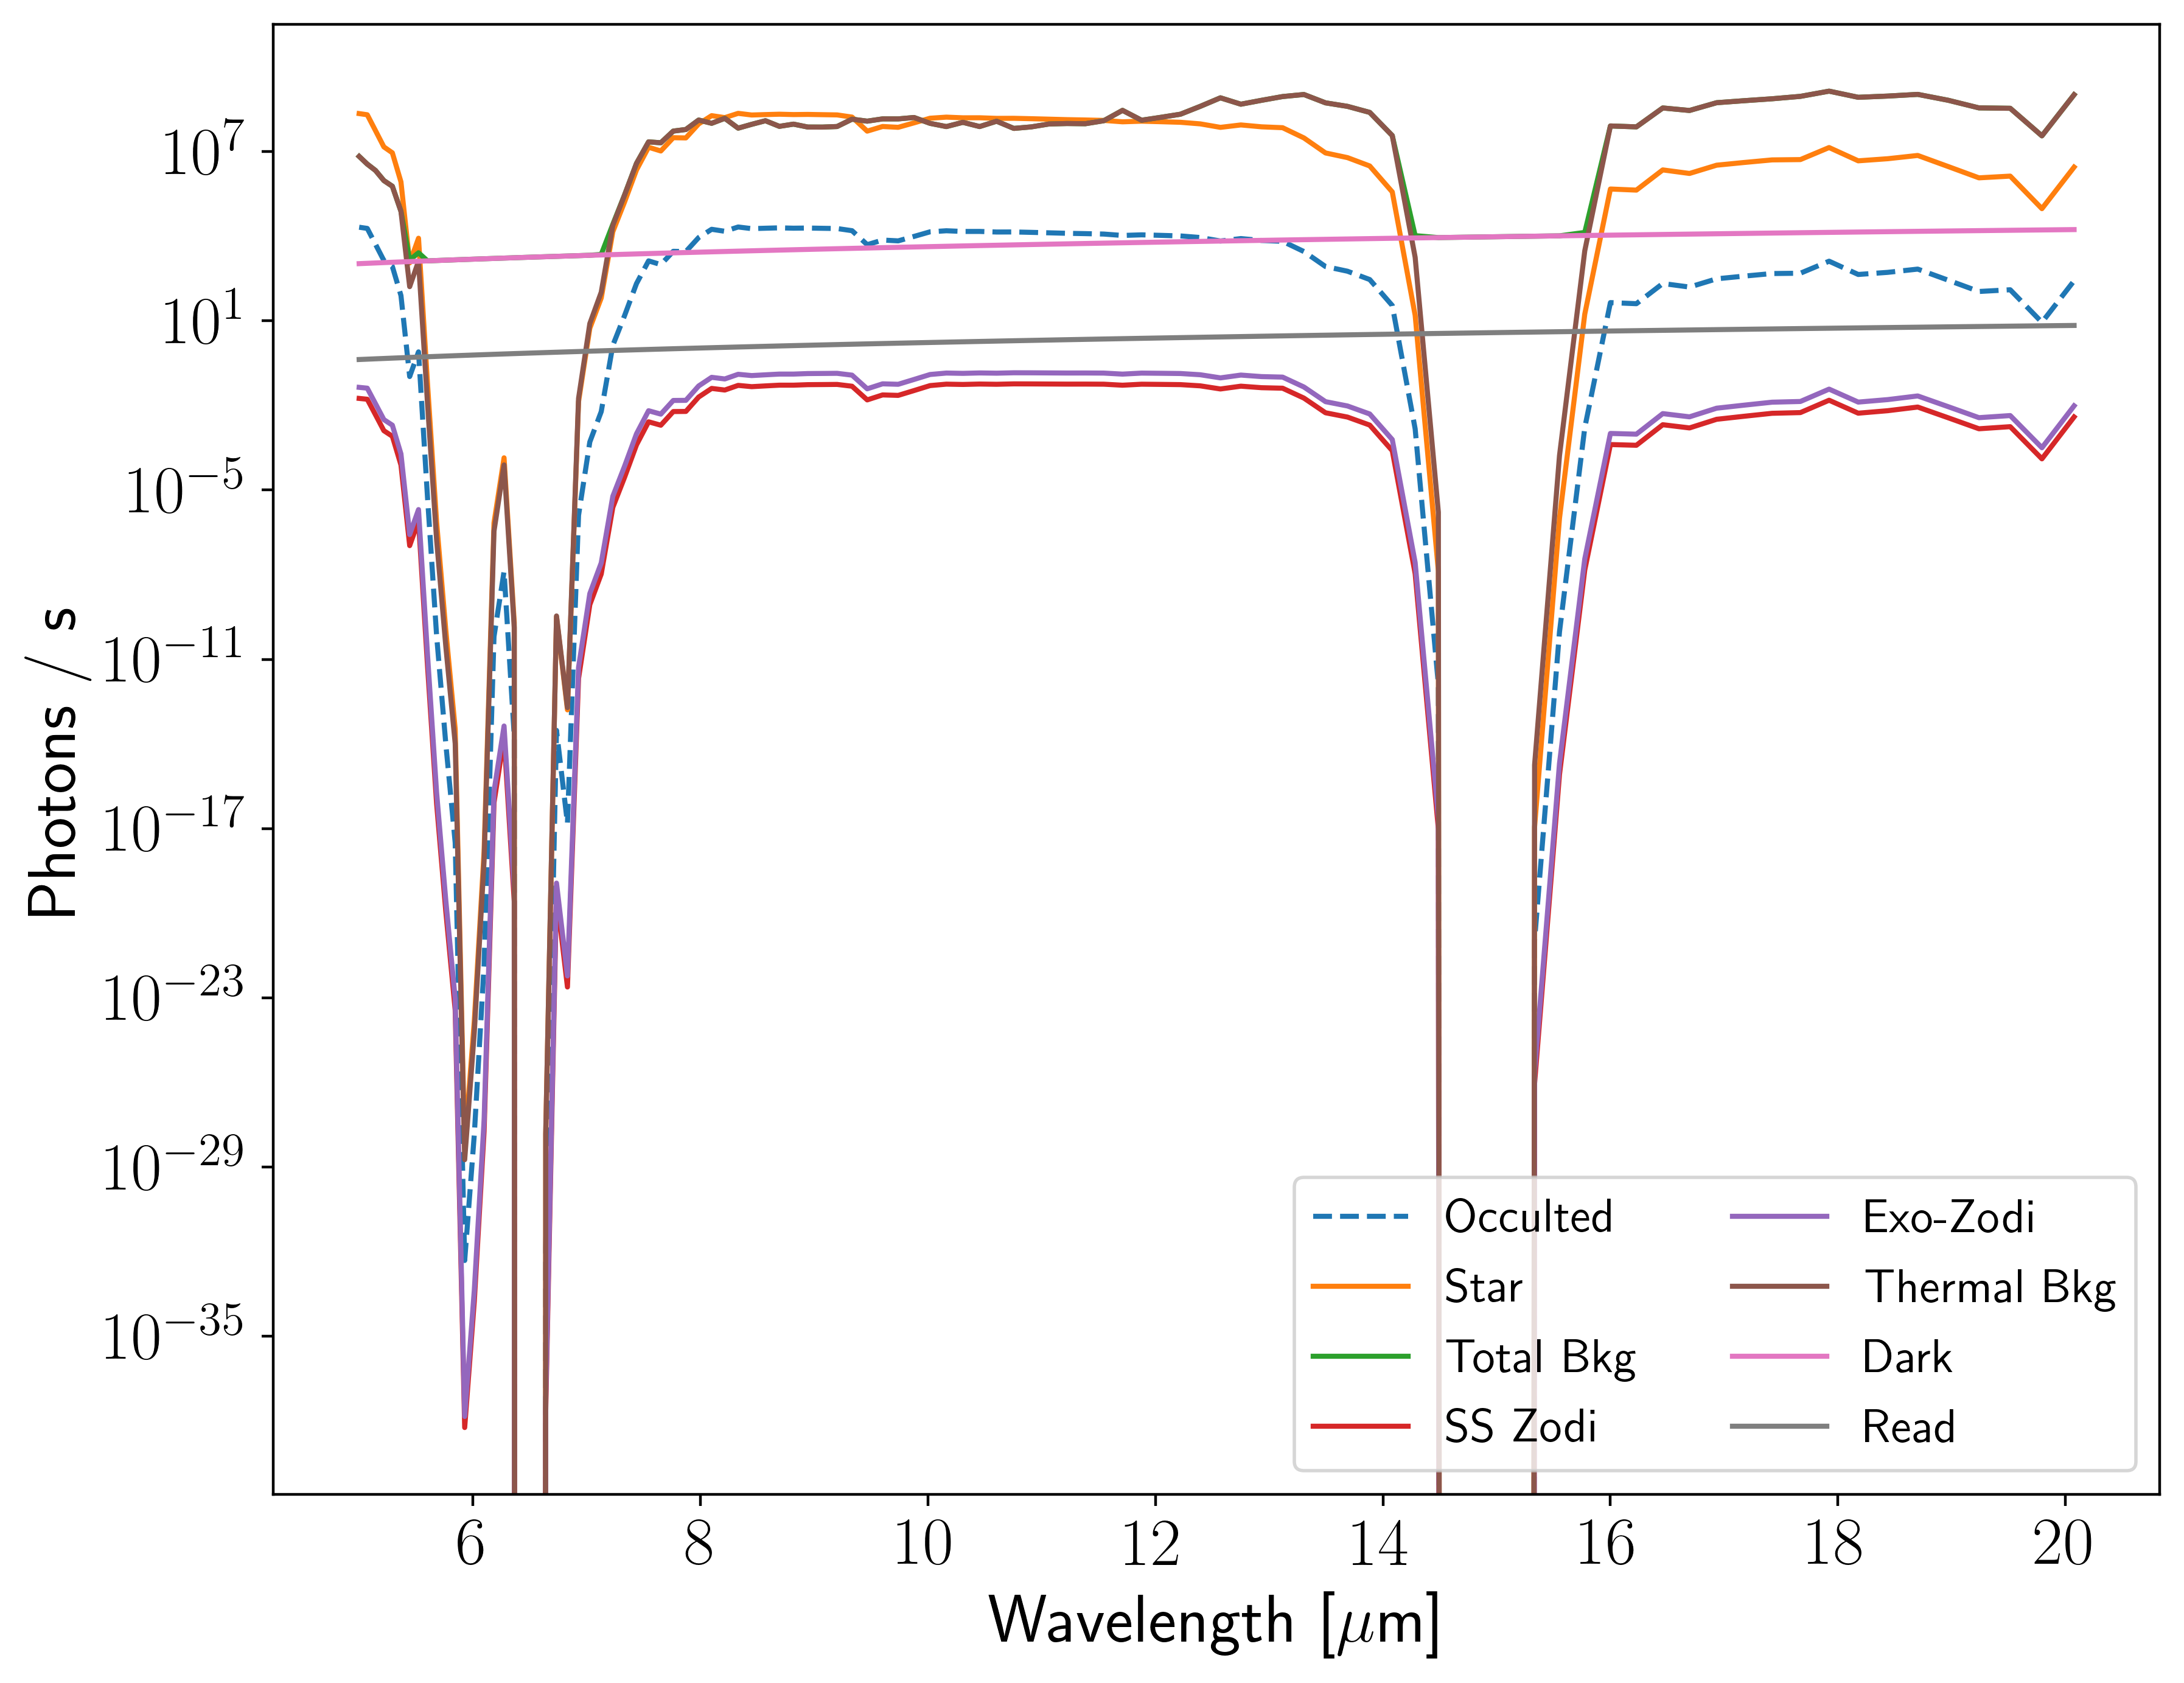

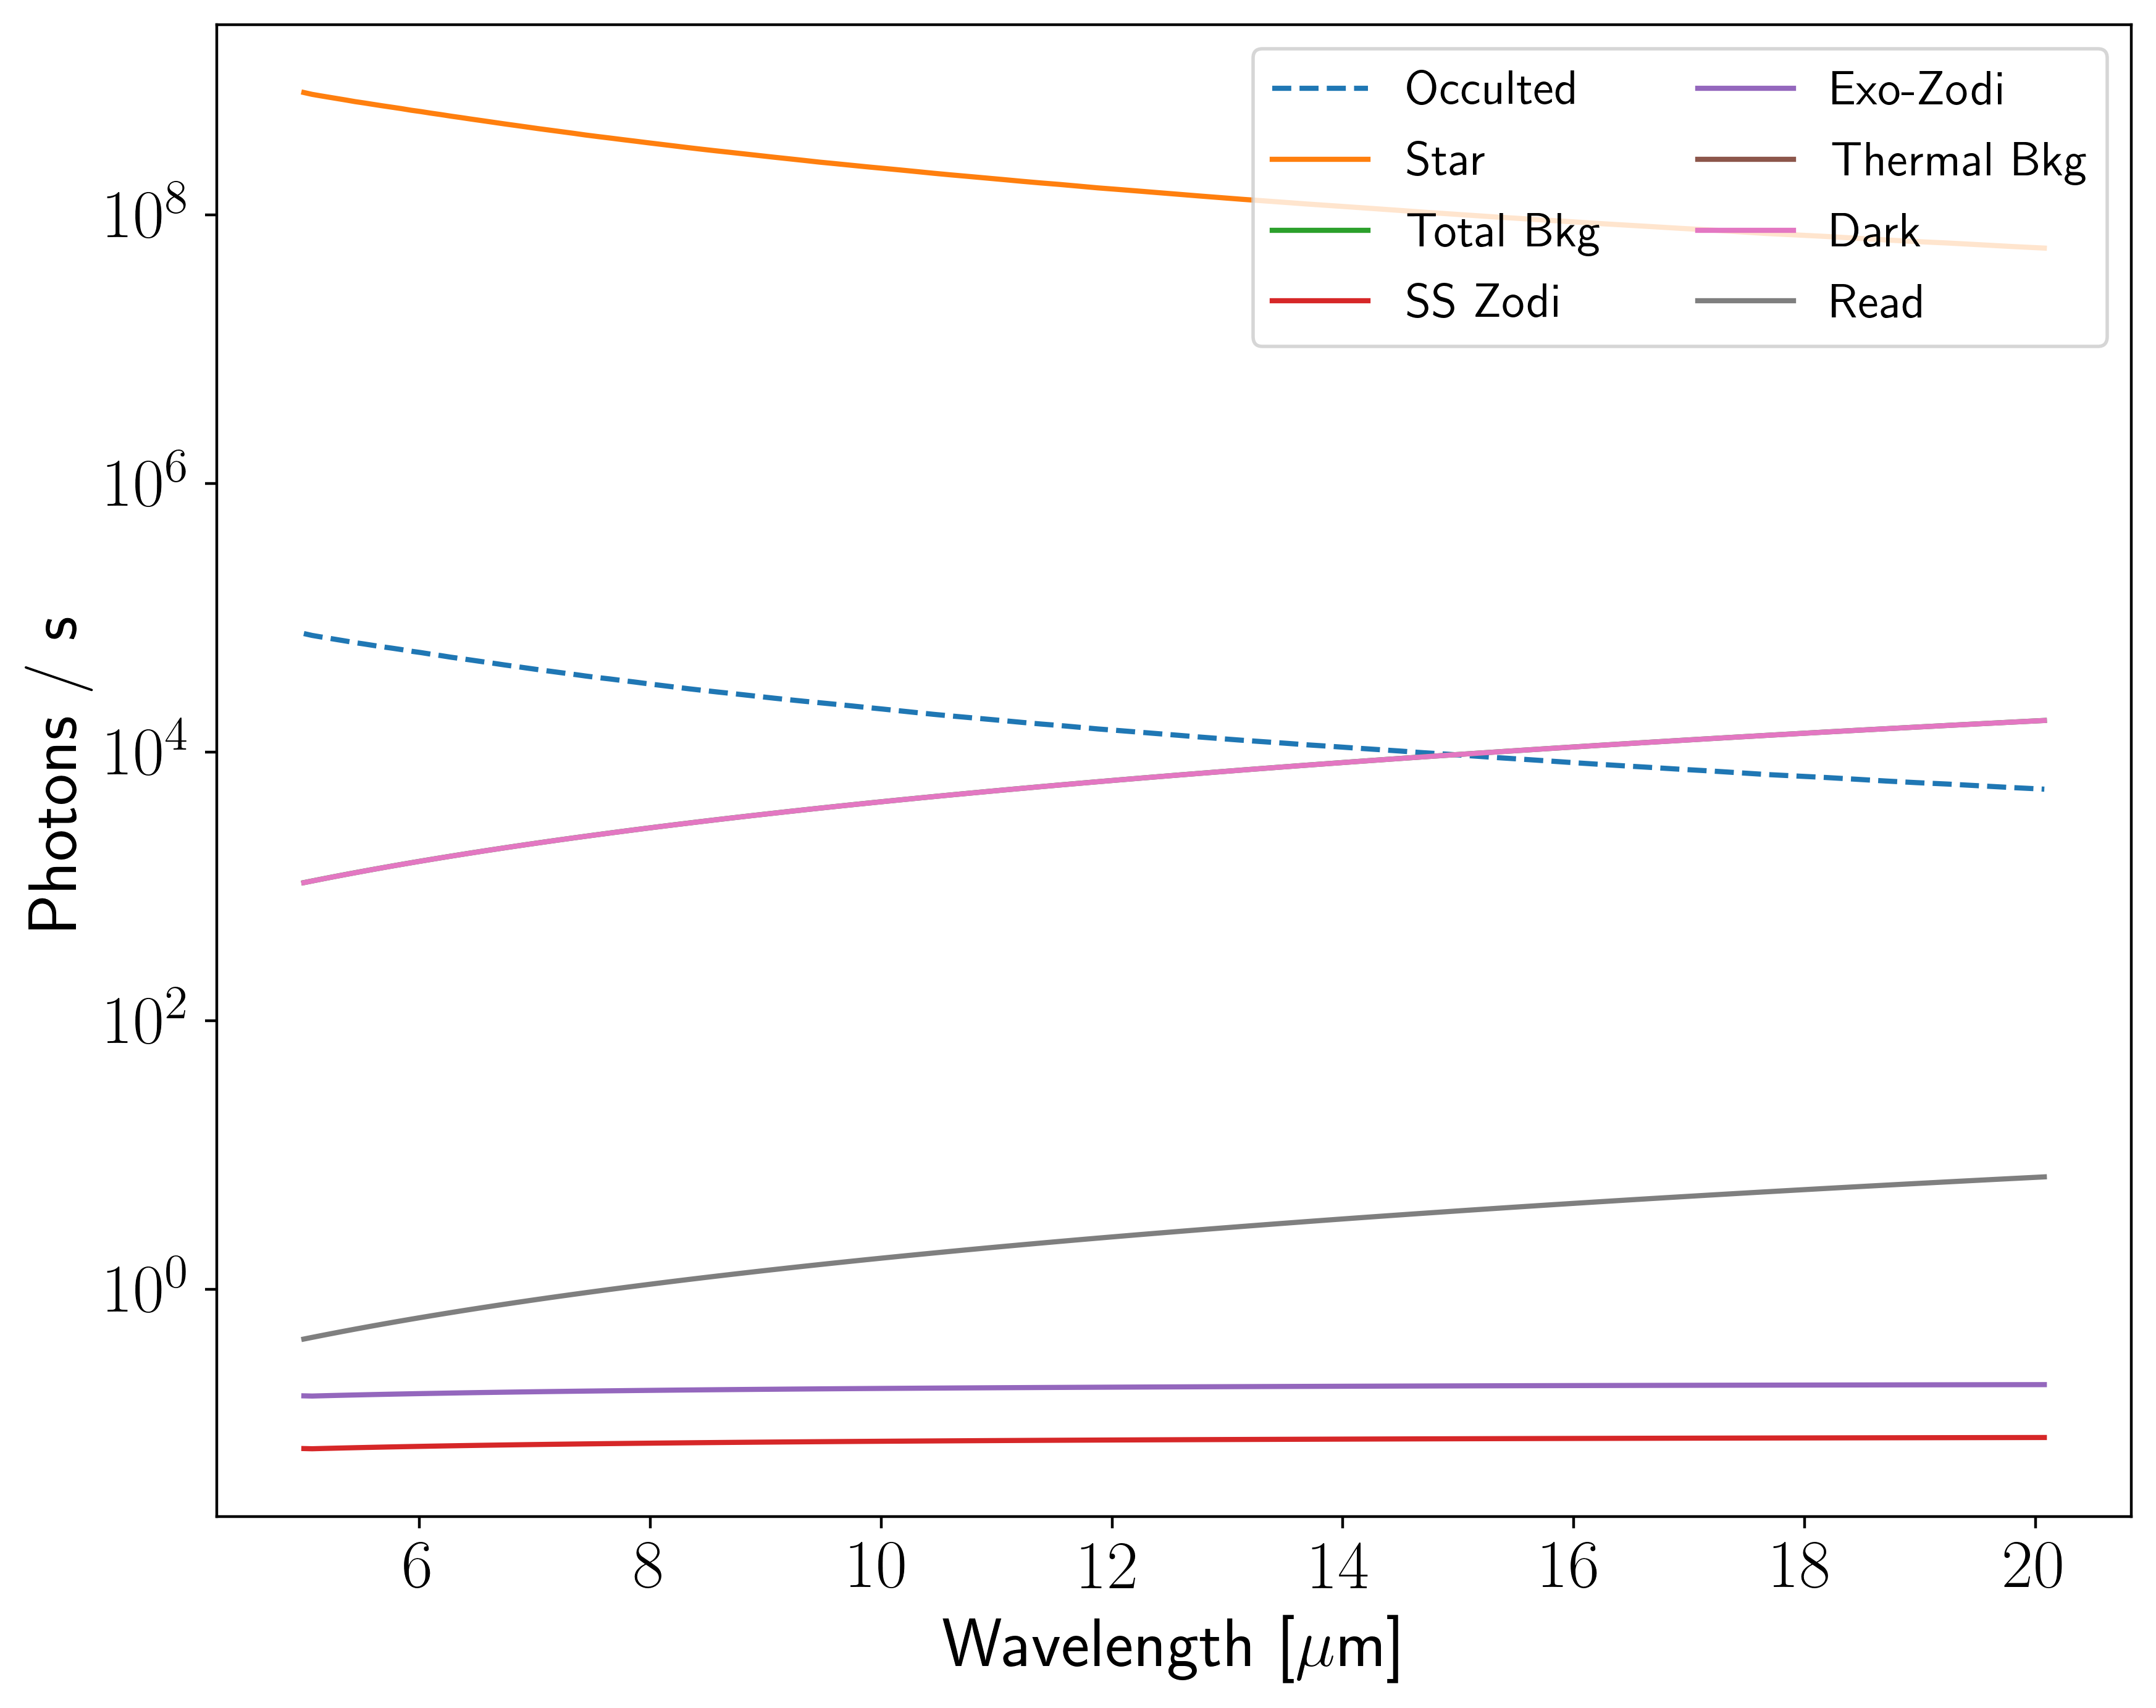

In [190]:
tn_sky.plot_count_rates()
tn_nosky.plot_count_rates()

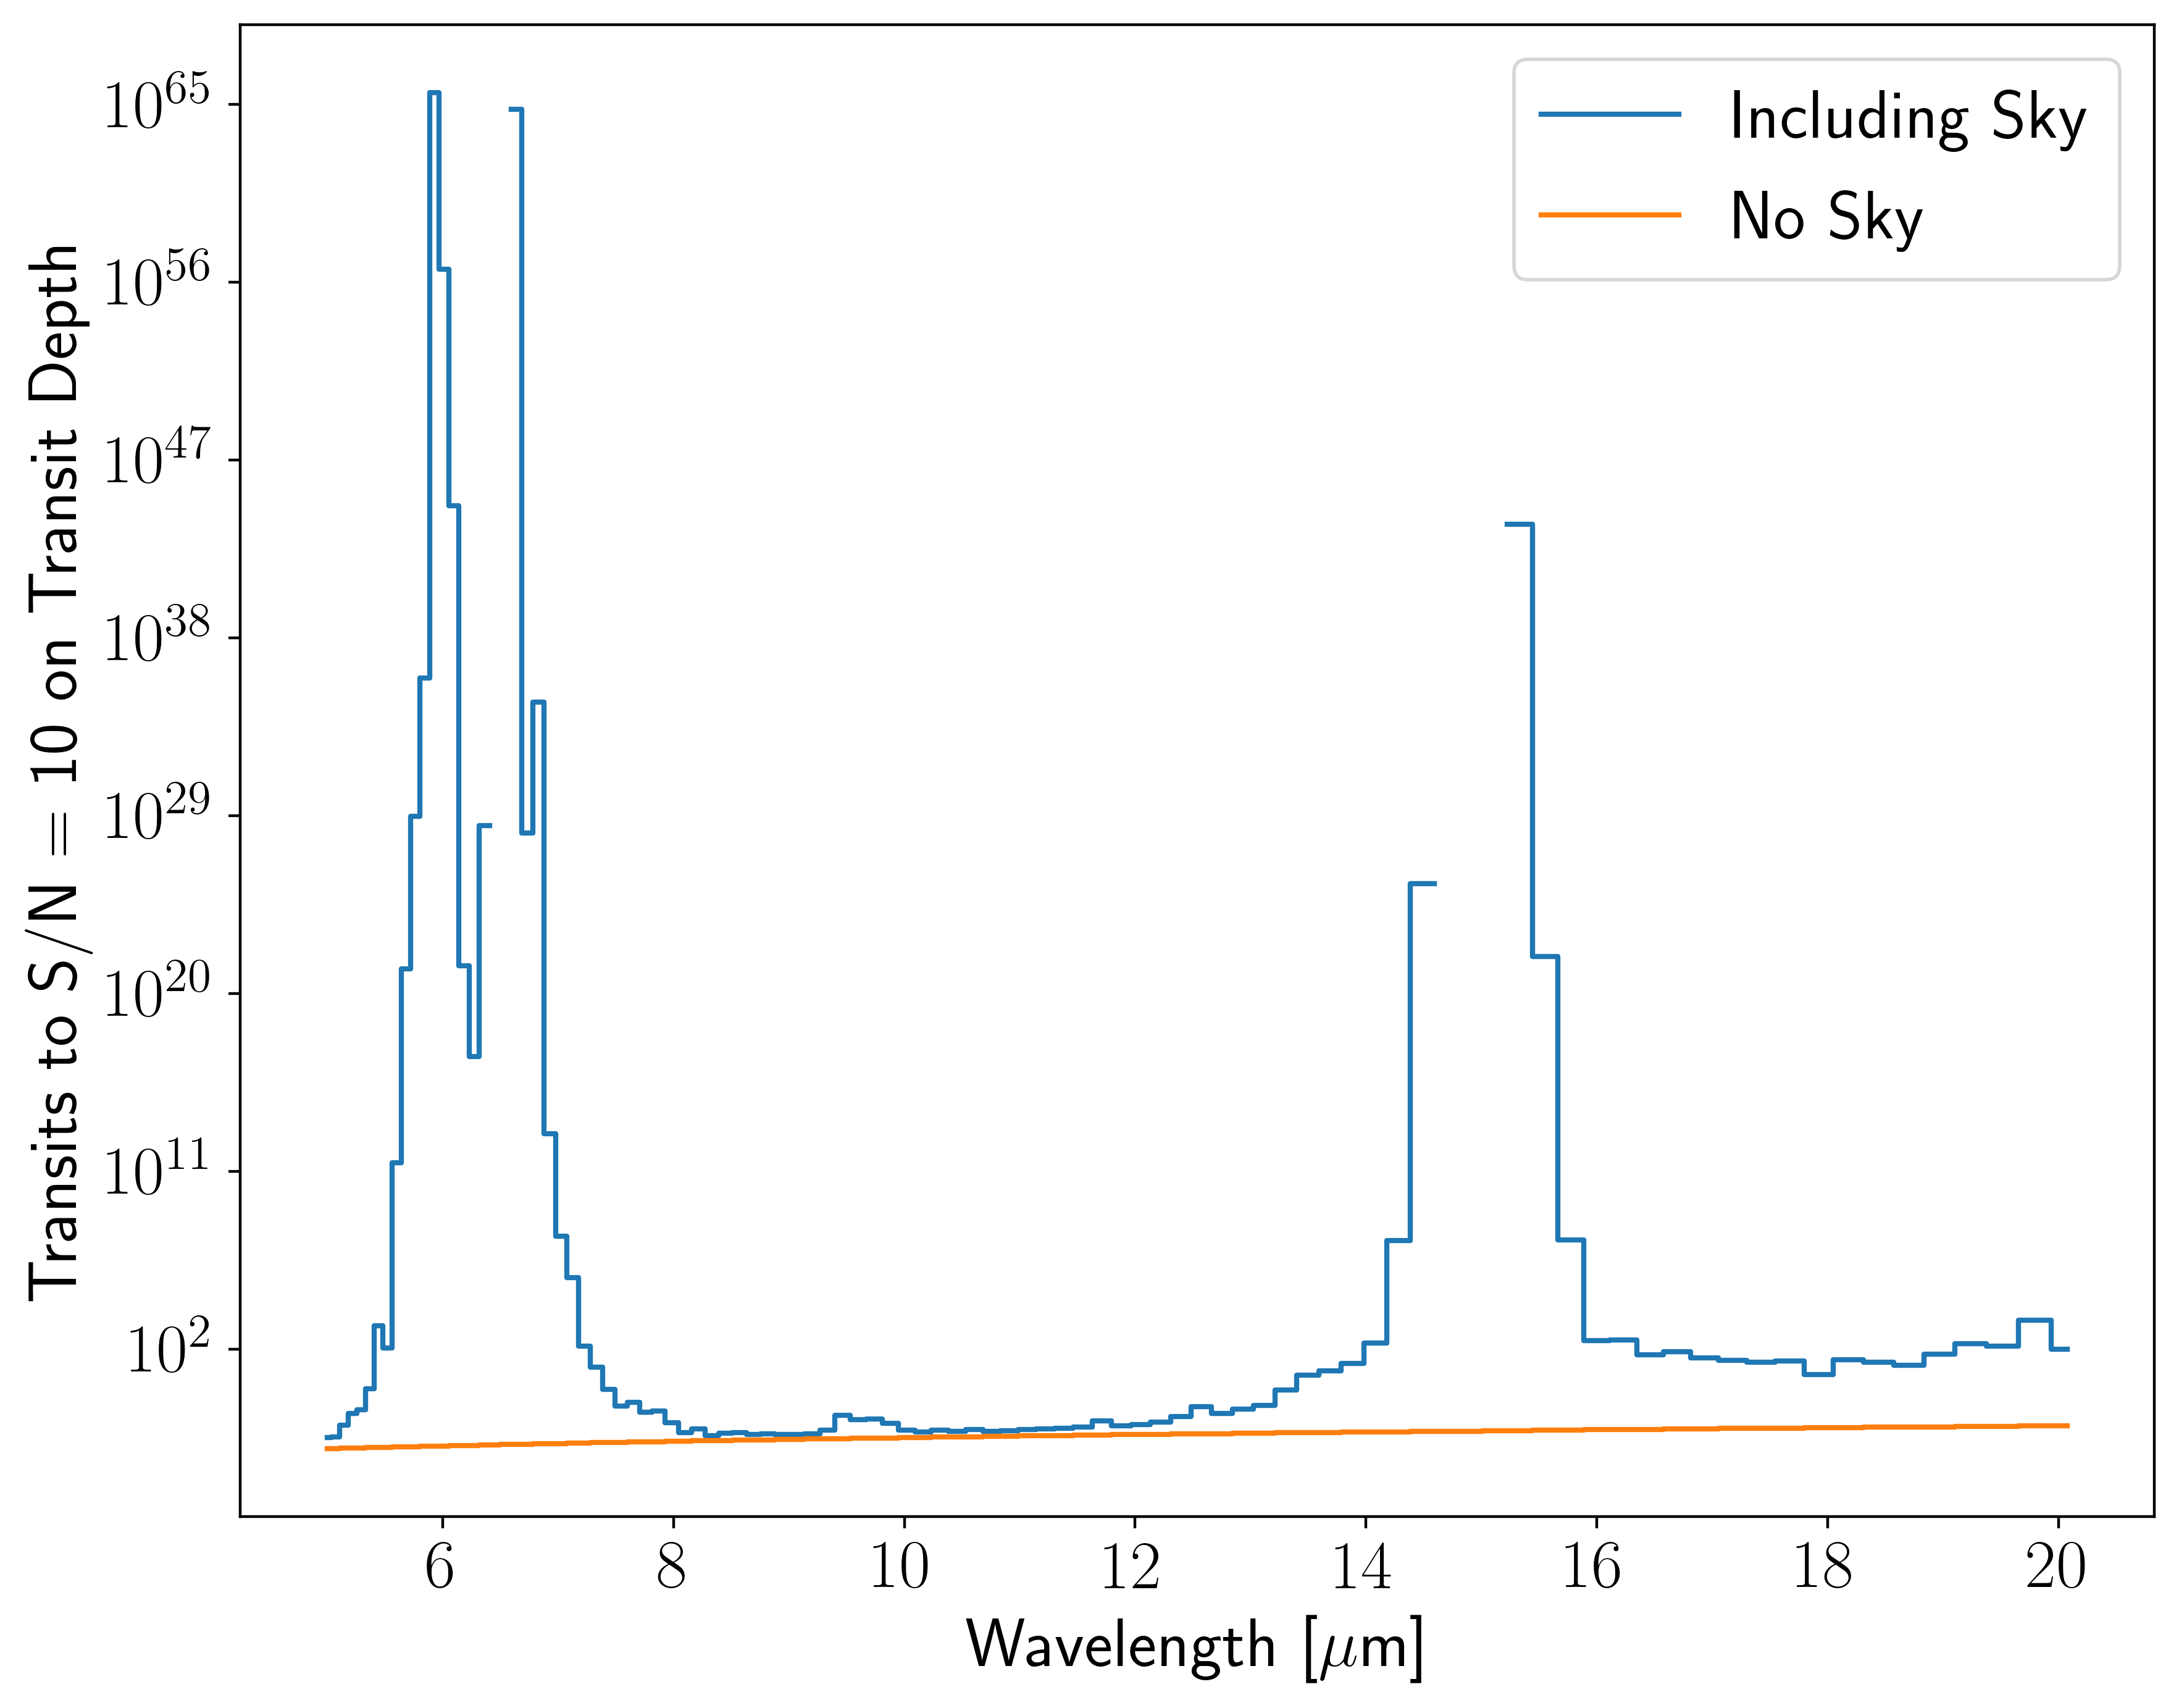

In [191]:
fig, ax = tn_sky.plot_ntran_to_wantsnr()
tn_nosky.plot_ntran_to_wantsnr(ax0=ax)
ax.plot(telescope.lammin, 0, color='C0', label='Including Sky')
ax.plot(telescope.lammin, 0, color='C1', label='No Sky')
ax.legend()

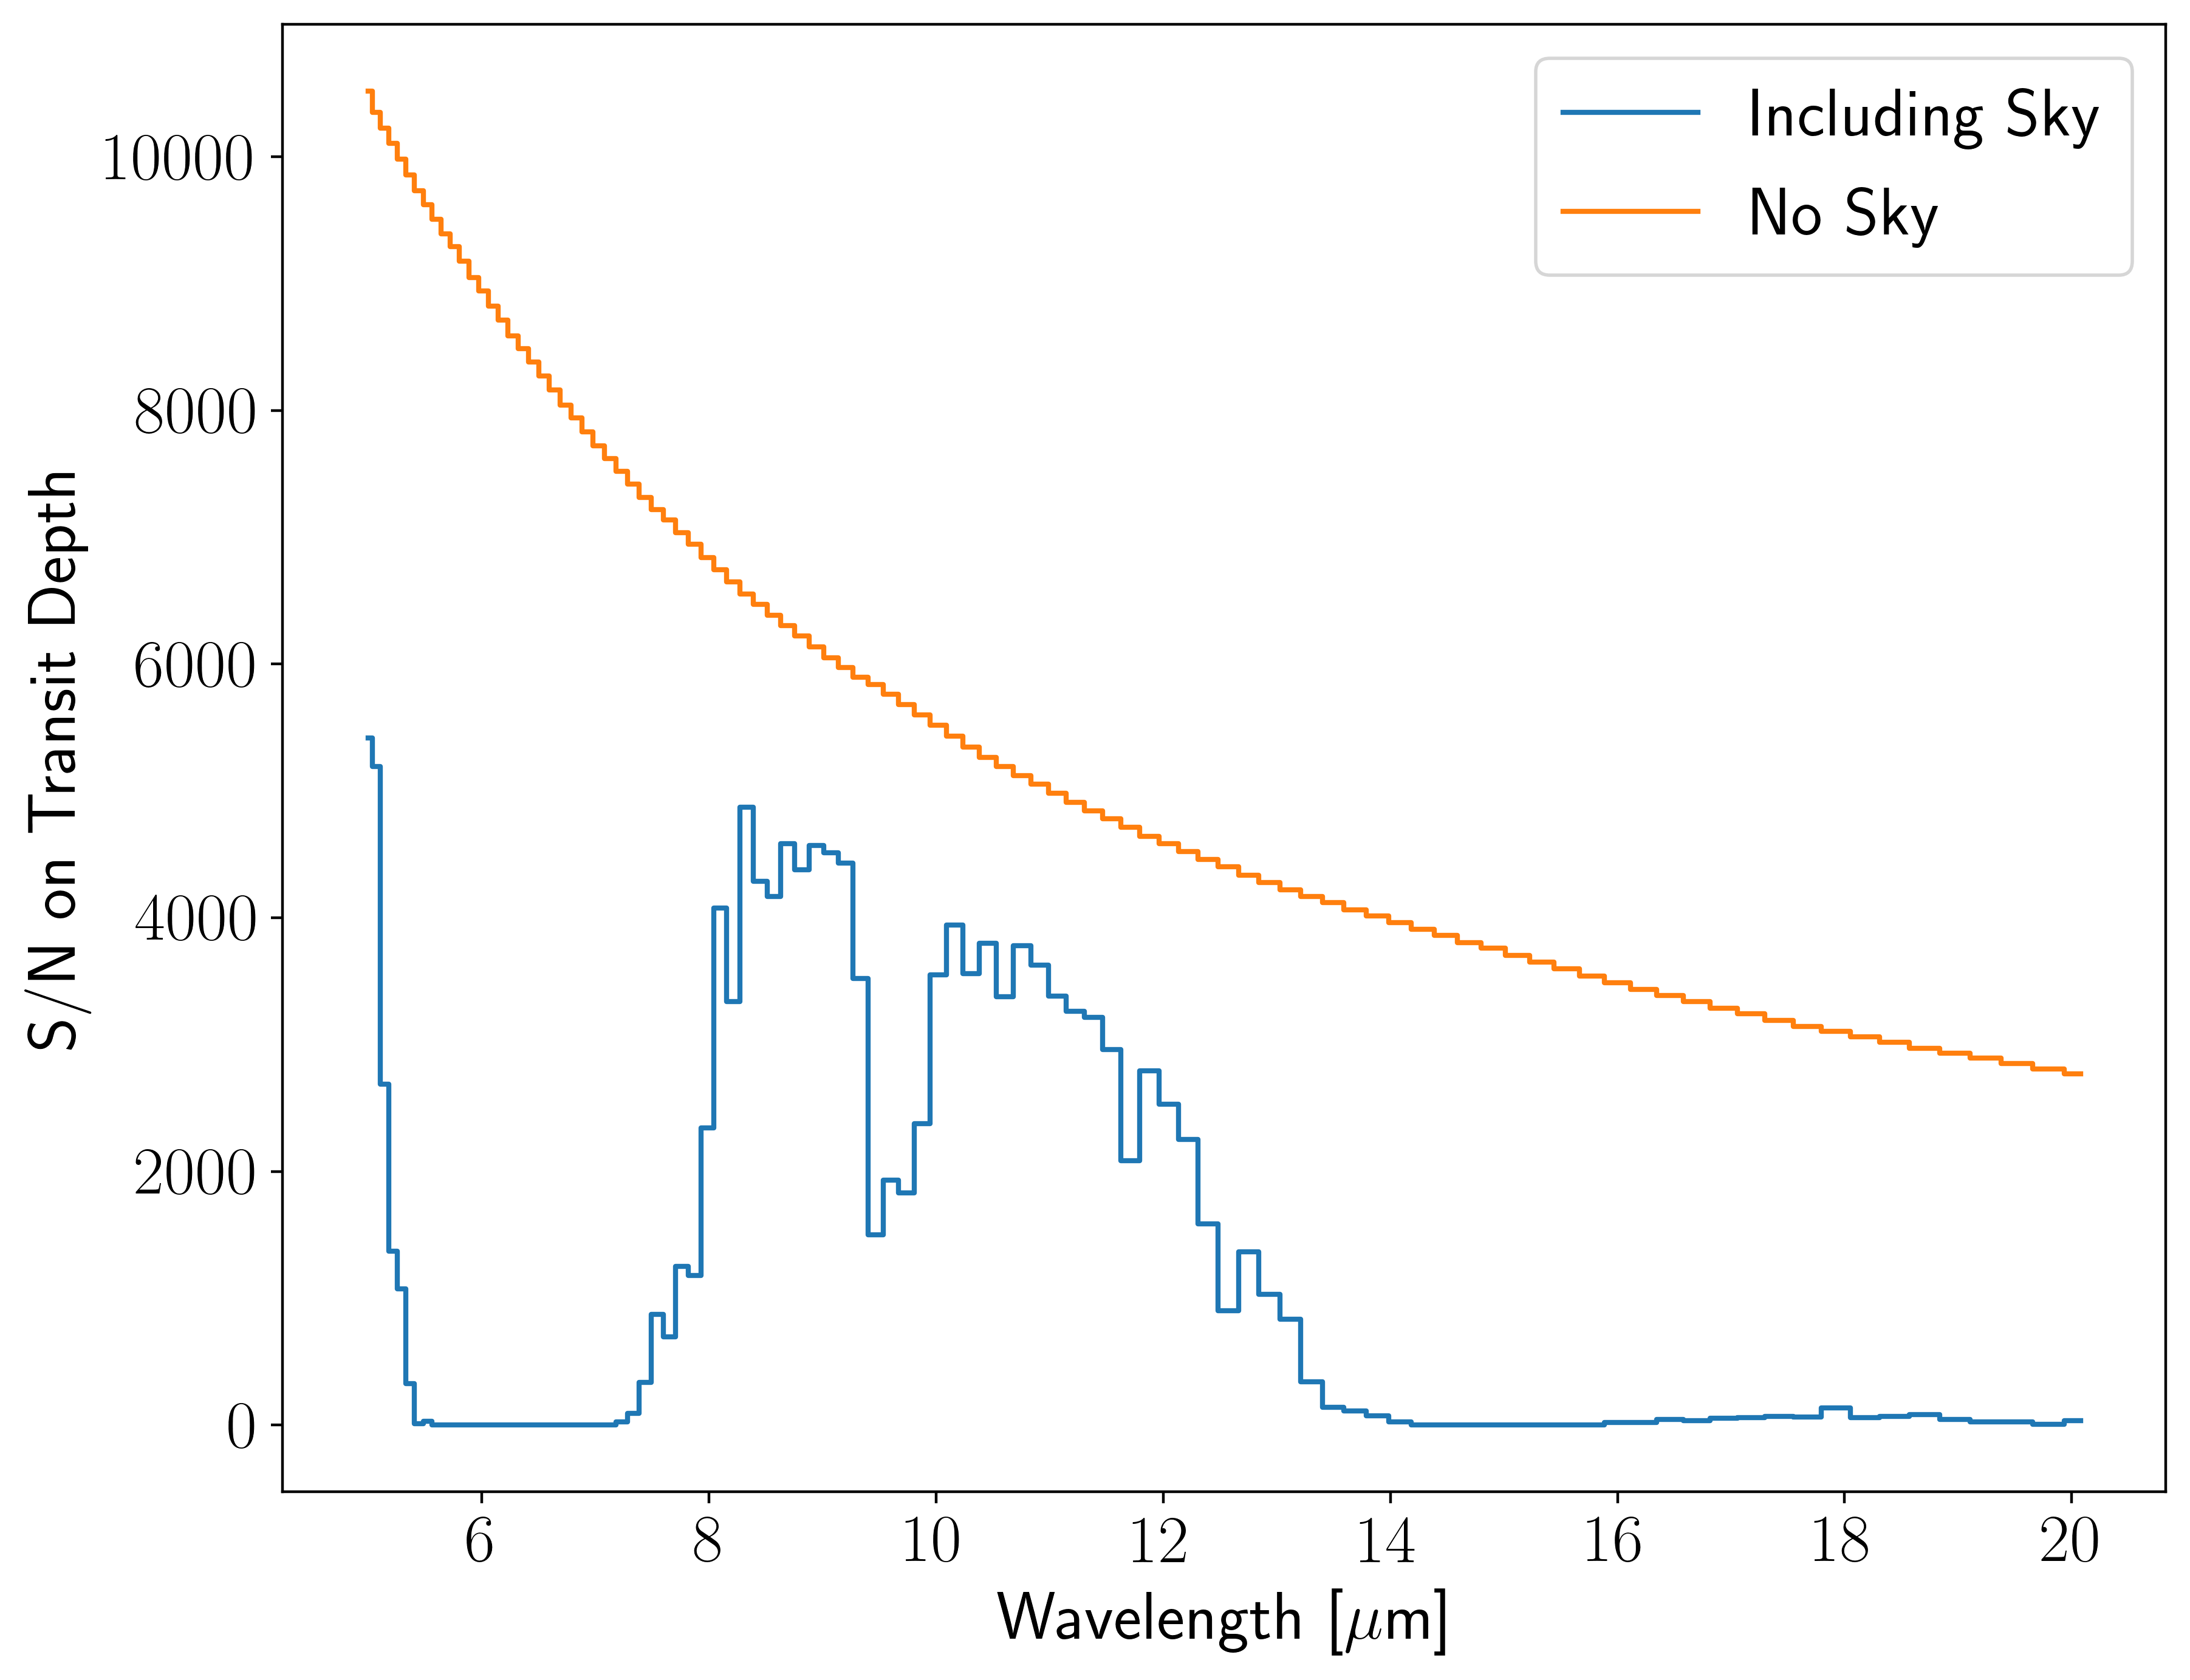

In [192]:
fig, ax = tn_sky.plot_SNRn()
tn_nosky.plot_SNRn(ax0=ax)
ax.plot(telescope.lammin, 0, color='C0', label='Including Sky')
ax.plot(telescope.lammin, 0, color='C1', label='No Sky')
ax.legend()